# Lesson 5 Human in the loop

Note: This notebook is running in a later version of langgraph that it was filmed with. The later version has a couple of key additions:
- Additional state information is stored to memory and displayed when using `get_state()` or `get_state_history()`.
- State is additionally stored every state transition while previously it was stored at an interrupt or at the end.
These change the command output slightly, but are a useful addtion to the information available.


In [ ]:
from dotenv import load_dotenv
_ = load_dotenv()
load_dotenv('/home/jovyan/work/.env') 


True

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated,List 
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

In [4]:
import sqlite3
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)

### ⚠️ 关于 SqliteSaver 初始化的版本兼容性说明

**为什么不能用 `SqliteSaver.from_conn_string(":memory:")`？**

在教学视频中，你可能看到的代码是：
```python
memory = SqliteSaver.from_conn_string(":memory:")
```

但在较新版本的 LangGraph 中，这段代码会导致 **TypeError**：
```
Invalid checkpointer provided. Expected BaseCheckpointSaver, 
received _GeneratorContextManager
```

**原因：**
- **旧版本**：`SqliteSaver.from_conn_string()` 直接返回 `SqliteSaver` 实例
- **新版本**：`SqliteSaver.from_conn_string()` 返回一个**上下文管理器** (_GeneratorContextManager)
  - 需要在 `with` 语句中使用
  - 不能直接传给 `checkpointer` 参数

**正确的解决方案（新版本）：**
```python
import sqlite3
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)
```

**关键点：**
1. **手动创建连接**：使用 `sqlite3.connect()` 创建数据库连接
2. **check_same_thread=False**：允许多线程访问（SQLite 默认只允许单线程）
3. **直接实例化**：将连接传给 `SqliteSaver(conn)` 构造函数

这样就能得到一个可以直接使用的 `SqliteSaver` 实例，避免类型不匹配的错误。

💡 **学习提示**：库更新后 API 可能变化，遇到教程代码不工作时，先检查版本差异！

In [5]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""

def reduce_messages(left:list[AnyMessage], right:list[AnyMessage]) -> list[AnyMessage]:
    # assign ids o messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],reduce_messages]

## 🔍 理解 `for...else` 语法

**易混淆点**: `else` 属于 `for` 循环，不是 `if` 语句！

### 标准格式:
```python
for item in iterable:
    if condition:
        break  # 跳出循环
else:
    # 只有循环正常结束（没有 break）才执行这里
    pass
```

### 本例中的逻辑:
```python
for i, existing in enumerate(merged):
    if existing.id == message.id:
        merged[i] = message  # 替换现有消息
        break                 # 找到了，退出循环
else:
    # 没有找到匹配的 ID（循环没有 break）
    merged.append(message)    # 添加新消息到末尾
```

### 等价的传统写法:
```python
found = False
for i, existing in enumerate(merged):
    if existing.id == message.id:
        merged[i] = message
        found = True
        break

if not found:
    merged.append(message)
```

### 实际例子:
```python
# 例子 1: break 被触发
for i in [1, 2, 3, 4, 5]:
    if i == 3:
        print(f"Found {i}!")
        break
else:
    print("Loop completed without break")
# 输出: Found 3!

# 例子 2: break 没有被触发
for i in [1, 2, 3, 4, 5]:
    if i == 10:
        print(f"Found {i}!")
        break
else:
    print("Loop completed without break")
# 输出: Loop completed without break
```

### 为什么使用 `for...else`?
✅ 代码更简洁（不需要 `found` 标志变量）  
✅ 意图更清晰（"找不到就执行 else"）  
✅ Python 惯用法（Pythonic）

### 缩进规则:
- `else` 与 `for` 对齐（同一级）
- `if` 在 `for` 内部（缩进一级）
- `else` **不属于** `if`，属于 `for`

In [6]:
# 测试 for...else 行为

print("测试 1: break 被触发（找到匹配）")
test_list = [1, 2, 3, 4, 5]
for i in test_list:
    if i == 3:
        print(f"  找到 {i}，break!")
        break
else:
    print("  循环正常结束（没有 break）")

print("\n测试 2: break 未触发（没找到匹配）")
for i in test_list:
    if i == 10:
        print(f"  找到 {i}，break!")
        break
else:
    print("  循环正常结束（没有 break）")

print("\n测试 3: 模拟 reduce_messages 逻辑")
merged = [{"id": "a", "text": "old"}, {"id": "b", "text": "old"}]
new_message = {"id": "c", "text": "new"}

for i, existing in enumerate(merged):
    if existing["id"] == new_message["id"]:
        print(f"  替换消息 {i}")
        merged[i] = new_message
        break
else:
    print(f"  没找到匹配，添加新消息")
    merged.append(new_message)

print(f"  结果: {merged}")

测试 1: break 被触发（找到匹配）
  找到 3，break!

测试 2: break 未触发（没找到匹配）
  循环正常结束（没有 break）

测试 3: 模拟 reduce_messages 逻辑
  没找到匹配，添加新消息
  结果: [{'id': 'a', 'text': 'old'}, {'id': 'b', 'text': 'old'}, {'id': 'c', 'text': 'new'}]


In [7]:
tool = TavilySearchResults(max_results = 2)

/tmp/ipykernel_15261/1329628019.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results = 2)


## Manual human approval

In [8]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

## 📖 `call_openai()` 方法逐行解析

```python
def call_openai(self, state: AgentState):
```
**定义方法**
- `self`: 指向 Agent 实例本身
- `state: AgentState`: 接收当前的 agent 状态（包含所有消息历史）

---

```python
    messages = state['messages']
```
**提取消息历史**
- 从 state 字典中取出 `'messages'` 键的值
- `messages` 是一个列表，包含所有历史对话：
  ```python
  [
    HumanMessage("What's the weather?"),
    AIMessage("Let me search..."),
    ToolMessage("Result: Sunny"),
    ...
  ]
  ```

---

```python
    if self.system:
```
**检查是否有系统提示词**
- `self.system` 是在 `__init__()` 中设置的系统提示
- 例如: `"You are a helpful research assistant..."`
- 如果存在系统提示（不为空字符串），执行下一行

---

```python
        messages = [SystemMessage(content=self.system)] + messages
```
**添加系统提示到消息开头**
- 创建 `SystemMessage` 对象，内容是 `self.system`
- 用 `+` 连接列表：`[SystemMessage] + [原有消息]`
- 结果：
  ```python
  [
    SystemMessage("You are a helpful assistant"),  # 新添加的
    HumanMessage("What's the weather?"),           # 原有的
    ...
  ]
  ```
- **为什么要这样？** LLM 需要系统提示在最前面来理解自己的角色

---

```python
    message = self.model.invoke(messages)
```
**调用 LLM 生成响应**
- `self.model` 是配置好的模型（ChatOpenAI/Ollama）
- `.invoke(messages)` 发送所有消息给 LLM
- LLM 返回一个新的 `AIMessage` 对象
- 例如返回:
  ```python
  AIMessage(
      content="Let me search for that...",
      tool_calls=[{...}]  # 可能包含工具调用
  )
  ```

---

```python
    return {'messages': [message]}
```
**返回更新后的状态**
- 返回一个字典，键是 `'messages'`，值是包含新消息的列表
- `[message]` 是单元素列表，包含 LLM 的新响应
- LangGraph 会自动使用 `reduce_messages()` 合并这个新消息到 state 中
- 结果：原有消息 + 新的 AIMessage

---

### 完整流程示例

**输入 state:**
```python
{
  'messages': [
    HumanMessage("What's the weather in SF?")
  ]
}
```

**执行过程:**
1. 提取 messages: `[HumanMessage(...)]`
2. 添加系统提示: `[SystemMessage("You are..."), HumanMessage(...)]`
3. 调用 LLM: 返回 `AIMessage(content="...", tool_calls=[...])`
4. 返回: `{'messages': [AIMessage(...)]}`

**最终 state (合并后):**
```python
{
  'messages': [
    HumanMessage("What's the weather in SF?"),
    AIMessage("Let me search...", tool_calls=[...])
  ]
}
```

---

### 关键要点

✅ **不修改原 state** - 只返回新增的消息  
✅ **SystemMessage 每次都添加** - 但不会重复（只在当前调用中）  
✅ **返回格式必须是字典** - LangGraph 要求节点返回 `dict`  
✅ **`reduce_messages()` 自动合并** - 不用担心重复添加消息

## 📖 `existing_action()` 方法逐行解析

```python
def existing_action(self, state: AgentState):
```
**定义条件检查方法**
- 用于 `add_conditional_edges()` 判断是否需要执行工具
- 返回 `True` → 跳转到 "action" 节点
- 返回 `False` → 结束 (END)

---

```python
    print(state)
```
**打印当前状态（调试用）**
- 显示整个 state 字典，方便查看当前有哪些消息
- 生产环境通常会删除这行

---

```python
    result = state['messages'][-1]
```
**获取最后一条消息**

### 🔍 为什么是 `[-1]`？

Python 负索引规则：
```python
messages = [msg0, msg1, msg2, msg3, msg4]
           # 0     1     2     3     4    正索引
           # -5   -4    -3    -2    -1    负索引

messages[-1]  # 获取最后一个元素 → msg4
messages[-2]  # 获取倒数第二个 → msg3
messages[0]   # 获取第一个元素 → msg0
```

**为什么要最后一条？**
- 消息顺序：Human → AI → Tool → AI → ...
- 最后一条消息是 LLM 刚返回的 `AIMessage`
- 我们需要检查这条 AI 消息是否包含工具调用

### 示例消息流：
```python
state['messages'] = [
    HumanMessage("What's the weather?"),       # [-3] 或 [0]
    AIMessage("Let me search...", 
              tool_calls=[{...}]),              # [-2] 或 [1] 
    ToolMessage("Result: Sunny"),              # [-1] 或 [2] ← 最新的
]
```

**此时:**
- `state['messages'][-1]` = `ToolMessage("Result: Sunny")`
- 但在 `call_openai()` 之后：
  ```python
  state['messages'] = [
      HumanMessage(...),
      AIMessage(..., tool_calls=[...])  # [-1] ← 最新的 AI 响应
  ]
  ```

---

```python
    return len(result.tool_calls) > 0
```
**检查是否有工具调用**

**拆解：**
1. `result.tool_calls` - AIMessage 的 `tool_calls` 属性
   - 如果 LLM 想调用工具，这是一个列表：
     ```python
     [
         {
             'name': 'tavily_search_results_json',
             'args': {'query': 'weather in SF'},
             'id': 'call_123',
             'type': 'tool_call'
         }
     ]
     ```
   - 如果 LLM 只给出文本回答，这是空列表：`[]`

2. `len(result.tool_calls)` - 工具调用的数量
   - 有工具：`len([...]) = 1, 2, 3...`
   - 无工具：`len([]) = 0`

3. `> 0` - 判断是否大于 0
   - `True` → 有工具调用 → 跳转到 "action" 节点执行工具
   - `False` → 无工具调用 → 结束 (END)，返回最终答案

---

### 完整流程示例

**场景 1: LLM 决定使用工具**
```python
# call_openai() 返回
state['messages'][-1] = AIMessage(
    content="Let me search for that...",
    tool_calls=[{'name': 'tavily_search_results_json', ...}]
)

# existing_action() 检查
result = state['messages'][-1]  # 获取这条 AIMessage
len(result.tool_calls) > 0      # len([...]) = 1 > 0 → True
# 返回 True → 跳转到 "action" 节点
```

**场景 2: LLM 直接给出答案**
```python
# call_openai() 返回
state['messages'][-1] = AIMessage(
    content="The weather in SF is sunny.",
    tool_calls=[]  # 空列表
)

# existing_action() 检查
result = state['messages'][-1]
len(result.tool_calls) > 0      # len([]) = 0 > 0 → False
# 返回 False → END，结束对话
```

---

### 🎯 总结

| 代码部分 | 作用 | 原因 |
|---------|------|------|
| `state['messages'][-1]` | 获取最后一条消息 | 最新的 AI 响应在最后 |
| `-1` | 负索引 | Python 快速访问最后元素的方式 |
| `result.tool_calls` | 工具调用列表 | LLM 返回的 function calling 信息 |
| `len(...) > 0` | 判断是否需要工具 | 决定下一步是执行工具还是结束 |

**等价写法（但不推荐）：**
```python
# 不用负索引
result = state['messages'][len(state['messages']) - 1]

# 更复杂的判断
if result.tool_calls and len(result.tool_calls) > 0:
    return True
else:
    return False
```

## 📖 `take_action()` 方法逐行解析

```python
def take_action(self, state: AgentState):
```
**定义工具执行方法**
- 当 LLM 决定使用工具时调用此方法
- 负责执行所有工具并收集结果

---

```python
    tool_calls = state['messages'][-1].tool_calls
```
**获取 LLM 要调用的工具列表**
- `state['messages'][-1]` - 最后一条消息（AIMessage）
- `.tool_calls` - LLM 返回的工具调用列表
- 例如：
  ```python
  [
      {
          'name': 'tavily_search_results_json',
          'args': {'query': 'weather in SF'},
          'id': 'call_abc123',
          'type': 'tool_call'
      },
      {
          'name': 'tavily_search_results_json',
          'args': {'query': 'weather in LA'},
          'id': 'call_def456',
          'type': 'tool_call'
      }
  ]
  ```

---

```python
    results = []
```
**创建空列表存储所有工具结果**

### 🔍 为什么需要 `results` 列表？

LLM 可能一次调用**多个工具**：
- 查询 SF 天气 + 查询 LA 天气
- 搜索两篇不同的文章
- 同时执行多个计算

我们需要：
1. 执行所有工具（循环）
2. 收集所有结果（append）
3. 一次性返回给 LLM（返回整个列表）

**类比：**
- `results` = 购物车 🛒
- 每执行一个工具 = 往购物车里放一件商品
- 最后返回整个购物车给 LLM

---

```python
    for t in tool_calls:
```
**遍历每个工具调用**
- `t` 是一个工具调用字典：
  ```python
  {
      'name': 'tavily_search_results_json',
      'args': {'query': 'weather in SF'},
      'id': 'call_abc123',
      'type': 'tool_call'
  }
  ```

---

```python
        print(f"Calling: {t}")
```
**打印正在调用的工具（调试用）**
- 显示：`Calling: {'name': '...', 'args': {...}, ...}`

---

```python
        result = self.tools[t['name']].invoke(t['args'])
```
**执行工具并获取结果**

**拆解：**
1. `t['name']` - 工具名称，如 `'tavily_search_results_json'`
2. `self.tools[...]` - 从工具字典中查找对应工具
   - `self.tools = {'tavily_search_results_json': TavilySearchResults(...)}`
3. `.invoke(t['args'])` - 调用工具，传入参数
   - `t['args'] = {'query': 'weather in SF'}`
4. `result` - 工具返回的结果（字符串或 JSON）
   ```python
   "[{'title': '...', 'url': '...', 'content': '...'}]"
   ```

---

```python
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
```
**将工具结果包装成 ToolMessage 并添加到列表**

### 🔍 详细拆解 `results.append()`

#### 1. `ToolMessage(...)` - 创建工具消息对象
LangChain 要求工具结果必须是 `ToolMessage` 类型，包含：
- `tool_call_id`: 工具调用的唯一 ID（对应 LLM 的请求）
- `name`: 工具名称
- `content`: 工具返回的实际内容（必须是字符串）

#### 2. 参数详解：
```python
ToolMessage(
    tool_call_id=t['id'],        # 'call_abc123' - 匹配 LLM 的工具调用 ID
    name=t['name'],              # 'tavily_search_results_json'
    content=str(result)          # "[{'title': '...', ...}]"
)
```

**为什么需要 `tool_call_id`？**
- LLM 发出多个工具调用，每个都有唯一 ID
- 返回结果时必须标注这是哪个调用的结果
- LLM 通过 ID 匹配请求和响应

#### 3. `results.append(...)` - 添加到列表
```python
# 第 1 次循环
results = []
results.append(ToolMessage(...))  # SF 天气结果
# 现在 results = [ToolMessage(SF)]

# 第 2 次循环  
results.append(ToolMessage(...))  # LA 天气结果
# 现在 results = [ToolMessage(SF), ToolMessage(LA)]
```

---

```python
        print("Back to the model!")
```
**所有工具执行完毕（调试信息）**

---

```python
        return {'messages': results}
```
**返回所有工具结果**
- `results` 是包含多个 `ToolMessage` 的列表
- LangGraph 会将这些消息合并到 state 中
- 然后回到 "llm" 节点，LLM 看到工具结果后继续思考

---

### 🎯 完整示例

**场景：LLM 同时查询两个城市的天气**

#### Step 1: LLM 返回两个工具调用
```python
state['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json', 'args': {'query': 'SF weather'}, 'id': 'call_1'},
    {'name': 'tavily_search_results_json', 'args': {'query': 'LA weather'}, 'id': 'call_2'}
]
```

#### Step 2: 执行 take_action()
```python
results = []  # 空购物车

# 第 1 次循环：执行 SF 查询
t = {'name': '...', 'args': {'query': 'SF weather'}, 'id': 'call_1'}
result = self.tools['tavily_...'].invoke({'query': 'SF weather'})
# result = "[{'title': 'SF Weather', 'content': 'Sunny, 70°F'}]"

results.append(ToolMessage(
    tool_call_id='call_1',
    name='tavily_search_results_json',
    content="[{'title': 'SF Weather', 'content': 'Sunny, 70°F'}]"
))
# results = [ToolMessage(call_1, SF结果)]

# 第 2 次循环：执行 LA 查询
t = {'name': '...', 'args': {'query': 'LA weather'}, 'id': 'call_2'}
result = self.tools['tavily_...'].invoke({'query': 'LA weather'})
# result = "[{'title': 'LA Weather', 'content': 'Cloudy, 65°F'}]"

results.append(ToolMessage(
    tool_call_id='call_2',
    name='tavily_search_results_json',
    content="[{'title': 'LA Weather', 'content': 'Cloudy, 65°F'}]"
))
# results = [ToolMessage(call_1, SF结果), ToolMessage(call_2, LA结果)]

# 返回所有结果
return {'messages': [ToolMessage(SF), ToolMessage(LA)]}
```

#### Step 3: 更新后的 state
```python
state['messages'] = [
    HumanMessage("Compare SF and LA weather"),
    AIMessage("Let me search...", tool_calls=[...]),
    ToolMessage(tool_call_id='call_1', content='SF: Sunny, 70°F'),  # 新增
    ToolMessage(tool_call_id='call_2', content='LA: Cloudy, 65°F')  # 新增
]
```

#### Step 4: 回到 llm 节点
LLM 看到两个工具结果，生成最终答案：
```python
AIMessage("SF is warmer (70°F) than LA (65°F) today.")
```

---

### 📊 关键要点总结

| 代码 | 作用 | 原因 |
|------|------|------|
| `results = []` | 创建空列表 | 准备收集多个工具结果 |
| `for t in tool_calls:` | 遍历工具调用 | LLM 可能调用多个工具 |
| `result = self.tools[...].invoke(...)` | 执行工具 | 实际调用搜索/计算等功能 |
| `ToolMessage(...)` | 包装结果 | LangChain 要求的标准格式 |
| `results.append(...)` | 添加到列表 | 收集所有结果 |
| `return {'messages': results}` | 返回所有结果 | 一次性给 LLM 所有信息 |

---

### 🐛 注意代码中的拼写错误

你的代码：
```python
results.append(ToolMessage(tool_call_od=t['id'], ...))  # ❌ od 拼错了
```

应该是：
```python
results.append(ToolMessage(tool_call_id=t['id'], ...))  # ✅ id
```

## 🔍 深入理解工具调用的三个关键部分

### 1. `t` 是什么？完整的工具调用对象

`t` 是一个字典，包含 LLM 想调用的工具的**所有信息**：

```python
t = {
    'name': 'tavily_search_results_json',     # 工具名称（调用哪个工具）
    'args': {'query': 'weather in SF'},       # 工具参数（传什么参数）
    'id': 'call_abc123',                      # 唯一标识符（标记这次调用）
    'type': 'tool_call'                       # 类型标记
}
```

**类比餐厅点餐：**
- `name` = 菜品名称："宫保鸡丁"
- `args` = 特殊要求：{"辣度": "微辣", "份量": "大份"}
- `id` = 订单号："A001"

---

### 2. `t['args']` - 工具参数（传什么参数进去）

```python
result = self.tools[t['name']].invoke(t['args'])
```

**完整示例：**

#### 场景：LLM 想搜索天气

**LLM 返回的工具调用：**
```python
t = {
    'name': 'tavily_search_results_json',
    'args': {                                 # ← 这就是 t['args']
        'query': 'weather in San Francisco',  # 搜索关键词
        'max_results': 2                      # 返回最多2个结果
    },
    'id': 'call_abc123'
}
```

**执行过程：**
```python
# 1. 获取工具名称
t['name']  # → 'tavily_search_results_json'

# 2. 从工具字典查找工具
self.tools = {
    'tavily_search_results_json': TavilySearchResults(max_results=2)
}
tool = self.tools['tavily_search_results_json']  # 找到搜索工具

# 3. 获取参数
t['args']  # → {'query': 'weather in San Francisco', 'max_results': 2}

# 4. 调用工具，传入参数
result = tool.invoke({'query': 'weather in San Francisco', 'max_results': 2})

# 5. 工具返回结果
result = [
    {
        'title': 'SF Weather Today',
        'url': 'https://...',
        'content': 'Sunny, 70°F'
    },
    {
        'title': 'SF Climate Info',
        'url': 'https://...',
        'content': 'Average temp is 65°F'
    }
]
```

**为什么需要 `args`？**
- 不同的查询需要不同的参数
- 例如：
  - 搜索 SF 天气：`{'query': 'SF weather'}`
  - 搜索 LA 天气：`{'query': 'LA weather'}`
  - 计算工具：`{'expression': '2 + 2'}`

---

### 3. `tool_call_id=t['id']` - 唯一标识符（匹配请求和响应）

```python
results.append(ToolMessage(
    tool_call_id=t['id'],        # ← 关键：标记这是哪个工具调用的结果
    name=t['name'],
    content=str(result)
))
```

### 🔍 为什么需要 ID？

**问题：LLM 一次可能调用多个工具**

```python
# LLM 返回的工具调用
tool_calls = [
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'SF weather'},
        'id': 'call_111'                    # ← ID 1
    },
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'LA weather'},
        'id': 'call_222'                    # ← ID 2
    },
    {
        'name': 'calculate',
        'args': {'expression': '70 - 65'},
        'id': 'call_333'                    # ← ID 3
    }
]
```

**如果没有 ID 会怎样？**
- LLM 无法知道哪个结果对应哪个查询
- 就像同时点了3个菜，上菜时不知道哪盘是谁的

**有了 ID：**
```python
# 工具调用 1
LLM 请求: {id: 'call_111', name: '...', args: {'query': 'SF weather'}}
我们返回: ToolMessage(tool_call_id='call_111', content='SF: Sunny, 70°F')

# 工具调用 2
LLM 请求: {id: 'call_222', name: '...', args: {'query': 'LA weather'}}
我们返回: ToolMessage(tool_call_id='call_222', content='LA: Cloudy, 65°F')

# LLM 通过 ID 匹配：
# call_111 → SF 天气
# call_222 → LA 天气
```

**类比外卖订单：**
- 你点了3个外卖（3个工具调用）
- 每个订单有订单号（tool_call_id）
- 外卖到了，通过订单号知道哪个是汉堡，哪个是披萨

---

### 4. 完整数据流示例

#### 用户问题：
"Compare the weather in SF and LA"

#### Step 1: LLM 决定调用两个工具
```python
state['messages'][-1].tool_calls = [
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'San Francisco weather today'},  # SF 查询参数
        'id': 'call_SF_001'
    },
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'Los Angeles weather today'},    # LA 查询参数
        'id': 'call_LA_002'
    }
]
```

#### Step 2: 执行第一个工具 (SF)
```python
t = tool_calls[0]  # 第一个工具调用

# 提取信息
t['name']  # → 'tavily_search_results_json'
t['args']  # → {'query': 'San Francisco weather today'}
t['id']    # → 'call_SF_001'

# 执行工具
tool = self.tools['tavily_search_results_json']
result = tool.invoke({'query': 'San Francisco weather today'})
# result = "[{'title': 'SF Weather', 'content': 'Sunny, 70°F'}]"

# 包装结果
results.append(ToolMessage(
    tool_call_id='call_SF_001',              # 标记：这是 call_SF_001 的结果
    name='tavily_search_results_json',
    content="[{'title': 'SF Weather', 'content': 'Sunny, 70°F'}]"
))
```

#### Step 3: 执行第二个工具 (LA)
```python
t = tool_calls[1]  # 第二个工具调用

# 提取信息
t['name']  # → 'tavily_search_results_json'
t['args']  # → {'query': 'Los Angeles weather today'}
t['id']    # → 'call_LA_002'

# 执行工具
result = tool.invoke({'query': 'Los Angeles weather today'})
# result = "[{'title': 'LA Weather', 'content': 'Cloudy, 65°F'}]"

# 包装结果
results.append(ToolMessage(
    tool_call_id='call_LA_002',              # 标记：这是 call_LA_002 的结果
    name='tavily_search_results_json',
    content="[{'title': 'LA Weather', 'content': 'Cloudy, 65°F'}]"
))
```

#### Step 4: 返回所有结果
```python
return {'messages': results}
# results = [
#     ToolMessage(tool_call_id='call_SF_001', content='SF: Sunny, 70°F'),
#     ToolMessage(tool_call_id='call_LA_002', content='LA: Cloudy, 65°F')
# ]
```

#### Step 5: LLM 接收结果
```python
# LLM 看到的消息历史：
[
    HumanMessage("Compare the weather in SF and LA"),
    AIMessage("Let me check both...", tool_calls=[
        {id: 'call_SF_001', ...},
        {id: 'call_LA_002', ...}
    ]),
    ToolMessage(tool_call_id='call_SF_001', content='SF: Sunny, 70°F'),   # 匹配 call_SF_001
    ToolMessage(tool_call_id='call_LA_002', content='LA: Cloudy, 65°F')   # 匹配 call_LA_002
]

# LLM 通过 ID 匹配，生成最终答案：
AIMessage("SF is warmer (70°F) than LA (65°F) today.")
```

---

### 📊 三个关键部分总结

| 部分 | 作用 | 例子 |
|-----|------|------|
| `t['name']` | 工具名称（调用哪个工具） | `'tavily_search_results_json'` |
| `t['args']` | 工具参数（传什么参数） | `{'query': 'SF weather'}` |
| `t['id']` | 唯一标识符（匹配请求和响应） | `'call_abc123'` |

**完整调用：**
```python
# 1. 找到工具
tool = self.tools[t['name']]

# 2. 传入参数执行
result = tool.invoke(t['args'])

# 3. 用 ID 标记结果
ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result))
```

**类比外卖：**
- `name` = 店名（去哪点餐）
- `args` = 订单详情（要什么菜）
- `id` = 订单号（匹配外卖和订单）

In [9]:
# 演示工具调用的完整流程

# 模拟 LLM 返回的工具调用
tool_calls = [
    {
        'name': 'search_weather',
        'args': {'city': 'San Francisco', 'units': 'fahrenheit'},  # ← 参数
        'id': 'call_001'                                            # ← ID
    },
    {
        'name': 'search_weather',
        'args': {'city': 'Los Angeles', 'units': 'fahrenheit'},
        'id': 'call_002'
    }
]

# 模拟工具字典
class MockWeatherTool:
    def invoke(self, args):
        city = args['city']
        # 模拟返回结果
        if 'Francisco' in city:
            return f"{city}: Sunny, 70°F"
        elif 'Angeles' in city:
            return f"{city}: Cloudy, 65°F"
        return f"{city}: Unknown"

tools = {
    'search_weather': MockWeatherTool()
}

# 执行工具调用（模拟 take_action）
results = []
for t in tool_calls:
    print(f"\n🔧 工具调用:")
    print(f"   name: {t['name']}")
    print(f"   args: {t['args']}")
    print(f"   id: {t['id']}")
    
    # 执行工具
    result = tools[t['name']].invoke(t['args'])
    print(f"   ✅ 结果: {result}")
    
    # 包装成 ToolMessage（这里简化，只用字典演示）
    tool_message = {
        'tool_call_id': t['id'],      # ← 关键：标记这是哪个调用的结果
        'name': t['name'],
        'content': result
    }
    results.append(tool_message)
    print(f"   📦 包装: {tool_message}")

print("\n\n📊 所有结果:")
for r in results:
    print(f"   ID {r['tool_call_id']}: {r['content']}")


🔧 工具调用:
   name: search_weather
   args: {'city': 'San Francisco', 'units': 'fahrenheit'}
   id: call_001
   ✅ 结果: San Francisco: Sunny, 70°F
   📦 包装: {'tool_call_id': 'call_001', 'name': 'search_weather', 'content': 'San Francisco: Sunny, 70°F'}

🔧 工具调用:
   name: search_weather
   args: {'city': 'Los Angeles', 'units': 'fahrenheit'}
   id: call_002
   ✅ 结果: Los Angeles: Cloudy, 65°F
   📦 包装: {'tool_call_id': 'call_002', 'name': 'search_weather', 'content': 'Los Angeles: Cloudy, 65°F'}


📊 所有结果:
   ID call_001: San Francisco: Sunny, 70°F
   ID call_002: Los Angeles: Cloudy, 65°F


In [10]:
from langchain_openai import ChatOpenAI

In [11]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [12]:
messages = [HumanMessage(content= "Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='80496e5a-bbeb-4d86-97d1-09a6ae33fcf5'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZKpKRDDr1vClx27wdIcmnm0N3PJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-18aa-77c3-aa0a-abb97c629278-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_RG9wr30kWHhv1z9MSMtnD4oM', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'inp

## 🚀 执行带有 Human-in-the-Loop 的 Agent

### 完整代码解析

```python
messages = [HumanMessage(content= "Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
```

---

### 📝 逐行详解

#### 1. 创建初始消息
```python
messages = [HumanMessage(content= "Whats the weather in SF?")]
```

**作用：** 创建用户的第一条消息

**详解：**
- `HumanMessage` = 人类消息类型（来自用户的输入）
- `content` = 消息内容："Whats the weather in SF?"
- `[...]` = 列表，因为 AgentState 要求 `messages` 是列表类型
- 这就是对话的起点

**等价于人类说：** "旧金山的天气怎么样？"

---

#### 2. 配置对话线程
```python
thread = {"configurable": {"thread_id": "1"}}
```

**作用：** 指定对话的唯一标识符，用于持久化存储

**详解：**
- `thread` = 线程配置字典
- `"configurable"` = LangGraph 的固定键名（必须这样写）
- `"thread_id"` = 对话线程的唯一 ID
- `"1"` = 这是第 1 个对话会话

**为什么需要 thread_id？**
1. **持久化存储**：`checkpointer=memory` 需要 ID 来保存状态
2. **多会话管理**：同时处理多个对话时区分不同用户
   - 用户 A：`thread_id="1"`
   - 用户 B：`thread_id="2"`
3. **状态恢复**：可以随时回到这个对话继续

**类比：**
- thread_id = 聊天室编号
- 每个聊天室有独立的消息历史
- 可以在不同房间同时聊天

---

#### 3. 流式执行 Agent
```python
for event in abot.graph.stream({"messages": messages}, thread):
```

**作用：** 启动 Agent 执行，并获取每个节点的输出事件

**详解：**
- `abot.graph` = 编译好的状态图（包含 llm、action 节点）
- `.stream(...)` = **流式执行**模式（逐步返回结果）
- `{"messages": messages}` = 初始状态（包含用户消息）
- `thread` = 传入线程配置

**stream() vs invoke():**
| 方法 | 行为 | 返回 |
|------|------|------|
| `stream()` | 每执行一个节点就返回一次 | 生成器，逐步输出 |
| `invoke()` | 执行完所有节点后返回 | 最终状态 |

**为什么用 stream？**
- 可以看到每一步的执行过程
- 实时查看 LLM 的输出和工具调用
- 更好的调试和监控

---

#### 4. 遍历每个事件
```python
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
```

**作用：** 打印每个节点的输出

**详解：**

##### 第一层循环：`for event in abot.graph.stream(...)`
- `event` = 单个节点执行后的输出
- 格式：`{'节点名': 节点返回的数据}`
- 例如：
  ```python
  event = {
      'llm': {'messages': [AIMessage("Let me search...", tool_calls=[...])]}
  }
  ```

##### 第二层循环：`for v in event.values()`
- `.values()` = 提取字典的所有值（忽略键名）
- `v` = 节点返回的实际数据
- 例如：
  ```python
  v = {'messages': [AIMessage(...)]}
  ```

##### 为什么需要两层循环？
1. **外层循环**：遍历所有节点的输出
   - 第 1 次：llm 节点的输出
   - 第 2 次：action 节点的输出（如果有）
   - 第 3 次：再次 llm 节点的输出
2. **内层循环**：提取每个节点的实际数据
   - event 是字典：`{'llm': {...}}`
   - .values() 提取：`{...}`
   - print 显示：具体内容

---

### 🎬 实际执行流程（Human-in-the-Loop）

因为我们设置了 `interrupt_before=["action"]`，执行会在工具调用前**暂停**！

#### 阶段 1: 首次执行（会暂停）
```python
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
```

**输出示例：**
```
{'messages': [HumanMessage('Whats the weather in SF?')]}
{'messages': [AIMessage(content='Let me search...', tool_calls=[{
    'name': 'tavily_search_results_json',
    'args': {'query': 'San Francisco weather'},
    'id': 'call_xxx'
}])]}
```

**然后就停了！** ⏸️

**为什么停了？**
- Agent 要调用 "action" 节点（执行工具）
- 但我们设置了 `interrupt_before=["action"]`
- 系统等待人类批准是否执行工具

---

#### 阶段 2: 检查中断状态
```python
# 查看当前状态
snapshot = abot.graph.get_state(thread)
print(snapshot.next)  # 输出: ('action',) - 下一步是 action 节点

# 查看待执行的工具调用
existing_message = snapshot.values["messages"][-1]
print(existing_message.tool_calls)
# [{
#     'name': 'tavily_search_results_json',
#     'args': {'query': 'San Francisco weather'},
#     'id': 'call_xxx'
# }]
```

**此时你可以：**
1. ✅ **批准**：继续执行工具
2. ❌ **拒绝**：修改或取消工具调用
3. ✏️ **修改**：更改工具参数

---

#### 阶段 3: 继续执行（批准工具调用）
```python
# 继续执行（不传新消息，使用现有状态）
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)
```

**输出示例：**
```
Calling: {'name': 'tavily_search_results_json', 'args': {...}, 'id': 'call_xxx'}
{'messages': [ToolMessage(tool_call_id='call_xxx', content='[{...}]')]}
Back to the model!
{'messages': [AIMessage('The weather in SF is sunny, 70°F')]}
```

**完整流程：**
1. ✅ 执行 action 节点（调用搜索工具）
2. 📊 返回工具结果 (ToolMessage)
3. 🤖 回到 llm 节点，生成最终答案
4. 🏁 结束 (END)

---

### 📊 完整消息流

```python
# 初始状态
state = {
    'messages': [
        HumanMessage("Whats the weather in SF?")
    ]
}

# ↓ llm 节点执行

state = {
    'messages': [
        HumanMessage("Whats the weather in SF?"),
        AIMessage("Let me search...", tool_calls=[...])  # 新增
    ]
}

# ⏸️ 暂停在 action 节点前（等待批准）

# ↓ 人类批准，继续执行

# ↓ action 节点执行

state = {
    'messages': [
        HumanMessage("Whats the weather in SF?"),
        AIMessage("Let me search...", tool_calls=[...]),
        ToolMessage(tool_call_id='...', content='Sunny, 70°F')  # 新增
    ]
}

# ↓ llm 节点再次执行

state = {
    'messages': [
        HumanMessage("Whats the weather in SF?"),
        AIMessage("Let me search...", tool_calls=[...]),
        ToolMessage(tool_call_id='...', content='Sunny, 70°F'),
        AIMessage("The weather in SF is sunny, 70°F")  # 新增
    ]
}

# 🏁 结束
```

---

### 🎯 关键要点

| 概念 | 说明 |
|------|------|
| `HumanMessage` | 用户输入的消息 |
| `thread_id` | 对话会话的唯一标识符，用于持久化 |
| `.stream()` | 流式执行，逐步返回每个节点的输出 |
| `interrupt_before` | 在指定节点前暂停，等待人类批准 |
| `event` | 单个节点的输出：`{'节点名': 数据}` |
| `.values()` | 提取字典的值，忽略节点名 |

---

### 💡 Human-in-the-Loop 的价值

**为什么要人工批准？**
1. **安全控制**：防止 AI 执行危险操作（删除文件、发送邮件）
2. **成本控制**：某些工具调用可能很贵（API 费用）
3. **质量把关**：检查 AI 的搜索关键词是否准确
4. **学习观察**：理解 AI 的思考过程

**使用场景：**
- 🔐 敏感操作：数据库写入、支付处理
- 💰 付费 API：高级搜索、图像生成
- 🎓 教学演示：展示 Agent 工作流程
- 🐛 调试开发：检查中间状态

In [13]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='80496e5a-bbeb-4d86-97d1-09a6ae33fcf5'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZKpKRDDr1vClx27wdIcmnm0N3PJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-18aa-77c3-aa0a-abb97c629278-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_RG9wr30kWHhv1z9MSMtnD4oM', 'type': 'tool_call'}], invalid_tool_calls=[],

In [14]:
abot.graph.get_state(thread).next

('action',)

## Continue after interrupt

In [15]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_RG9wr30kWHhv1z9MSMtnD4oM', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'San Francisco, CA Weather Conditions | Weather Underground\', \'url\': \'https://www.wunderground.com/weather/us/ca/san-francisco\', \'content\': "# San Francisco, CA Weather Conditionsstar\\\\_ratehome\\n\\nicon\\n\\nThank you for reporting this station. We will review the data in question.\\n\\nYou are about to report this weather station for bad data. Please select the information that is incorrect.\\n\\nSee more\\n\\n(Reset Map)\\n\\nNo PWS\\n\\nReset Map, or Add PWS.\\n\\naccess\\\\_time 2:40 AM PST on February 18, 2026 (GMT -8) | Updated 20 seconds ago\\n\\nicon\\n\\nShowers in the Vicinity\\n\\nTomorrow\'s temperature is forecast to be NEARLY THE SAME as today.\\n\\nicon\\nicon\\nicon\\nicon\\nicon\\nicon\\nicon\\nicon\\nAccess Logo\\n\\nWe recognize 

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='80496e5a-bbeb-4d86-97d1-09a6ae33fcf5'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZKpKRDDr1vClx27wdIcmnm0N3PJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-18aa-77c3-aa0a-abb97c629278-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_RG9wr30kWHhv1z9MSMtnD4oM', 'type': 'tool_call'}], invalid_tool_calls=[],

In [17]:
abot.graph.get_state(thread).next

()

In [ ]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens'

## Modify State

Run untill th einterrupt and the modify the state

In [22]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id" : "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens'

In [23]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

In [24]:
current_values = abot.graph.get_state(thread)

In [25]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 1749, 'total_tokens': 1770, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZNKcPTGCnjdz564soowC3wyJDYf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705c-6ef9-7053-9595-92f31ff57178-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_2HT4hJGjqhaGFEt0U1e39kmV', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 1749, 'output_tokens': 21, 'total_tokens': 1770, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reason

In [26]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_2HT4hJGjqhaGFEt0U1e39kmV',
  'type': 'tool_call'}]

In [28]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
     'args': {'query': 'current weather in louisiana'},
     'id': _id}
]

In [29]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens'

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10cb99-3402-67b7-8007-d51db2e0221a'}}

In [30]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

In [31]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in louisiana'}, 'id': 'call_2HT4hJGjqhaGFEt0U1e39kmV', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Weather Forecast for Louisiana this Wednesday, February 18\', \'url\': \'https://www.heraldousa.com/trending/weather-forecast-for-louisiana-this-wednesday-february-18-mild-weather-and-cloudy-skies-20260218-0025.html\', \'content\': "## Extended Forecast for the Next Three Days\\n\\nNOAA\'s report details the following changes:  \\nFebruary 19, 2026: High of 80°F and low of 63°F, persistent clouds with a breeze of 3 mph.  \\nFebruary 20, 2026: Heat of 82°F and low of 67°F, cloudy skies and a breeze of 2.5 mph.  \\nFebruary 21, 2026: Drop to 77°F and low of 69°F, light rain with a breeze of 2.5 mph.\\n\\nThe trend for the rest of the week shows a gradual increase in heat, reaching 82°F on Friday. However, a change in weather is expected on Saturday with the arriva

## 🎯 Human-in-the-Loop 三大核心模式

这个 Lesson 演示了三种控制 Agent 执行的方式，从简单批准到复杂状态修改。

---

## 模式 1️⃣: 简单批准 - 继续执行

### 场景：Agent 暂停在工具调用前，你检查后直接批准

```python
# 1. 查看当前状态
abot.graph.get_state(thread)          # 完整状态信息
abot.graph.get_state(thread).next     # 输出: ('action',) - 下一步是 action 节点

# 2. 批准并继续执行
for event in abot.graph.stream(None, thread):  # ← 关键: 传入 None 而不是新消息
    for v in event.values():
        print(v)

# 3. 检查是否完成
abot.graph.get_state(thread)          # 查看最终状态
abot.graph.get_state(thread).next     # 输出: () - 空元组表示已完成
```

### 🔍 关键点解析

#### `abot.graph.get_state(thread)` - 获取当前状态
返回一个状态快照对象，包含：
```python
StateSnapshot(
    values={
        'messages': [HumanMessage(...), AIMessage(...)]
    },
    next=('action',),           # ← 下一步要执行的节点
    config={...},
    metadata={...},
    created_at='...',
    parent_config={...}
)
```

#### `.next` 属性 - 检查下一步
- `('action',)` - 元组，包含待执行的节点名
- `()` - 空元组，表示没有下一步（已完成）
- 用于判断是否需要继续执行

#### `stream(None, thread)` - 从中断点继续
- **第一个参数 `None`**: 不添加新消息，使用现有状态继续
- **对比初次执行**: `stream({"messages": [...]}, thread)` 传入初始消息
- **效果**: 从暂停的节点（action）继续执行

---

## 模式 2️⃣: 交互式批准循环 - 每一步都询问

### 场景：多次工具调用，每次都要人工确认

```python
# 1. 开始新对话
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}  # ← 新的线程 ID

# 2. 初次执行（会在第一个工具调用前暂停）
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

# 3. 循环批准：只要还有下一步就继续询问
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed?")  # ← 等待用户输入
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)
```

### 🔍 详细解析

#### `while abot.graph.get_state(thread).next:`
**条件判断：** 只要 `.next` 不为空就继续循环

**执行流程：**
```python
# 第 1 次循环
.next = ('action',)  # 有待执行节点 → 条件为 True
→ 询问用户是否继续
→ 如果批准，执行 action 节点
→ action 执行完后回到 llm 节点

# 第 2 次循环（如果 LLM 又调用工具）
.next = ('action',)  # 又要执行 action → 条件为 True
→ 再次询问用户

# 第 N 次循环（LLM 给出最终答案）
.next = ()  # 空元组 → 条件为 False → 退出循环
```

#### `input("proceed?")` - 等待人工决策
- 暂停程序，等待用户输入
- 输入 "y" → 继续执行
- 输入其他 → 中止（break）

#### 为什么需要循环？
**问题：** Agent 可能需要多次工具调用
```
User: "Compare SF and LA weather, then tell me which is better for hiking"

执行流程:
1. LLM 决定搜索 SF 天气 → 暂停 (第 1 次批准)
2. 执行搜索 → 返回 LLM
3. LLM 决定搜索 LA 天气 → 暂停 (第 2 次批准)
4. 执行搜索 → 返回 LLM
5. LLM 分析并给出最终答案 → 结束
```

**循环的价值：**
- 每一步都可以检查和控制
- 防止 AI 连续执行多个操作
- 在任何时候都可以中止

---

## 模式 3️⃣: 修改状态 - 纠正 AI 的决策

### 场景：AI 理解错误，你要修改它的工具调用参数

```python
# 1. 开始新对话
messages = [HumanMessage("Whats the weather in LA?")]  # LA = Los Angeles
thread = {"configurable": {"thread_id": "3"}}

# 2. 执行到中断
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
# 输出: AIMessage 想调用 tavily_search_results_json，查询 "weather in Los Angeles"

# 3. 获取当前状态
current_values = abot.graph.get_state(thread)

# 4. 查看最后一条消息（AI 的工具调用）
current_values.values['messages'][-1]
# AIMessage(tool_calls=[{'name': '...', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_xxx'}])

# 5. 查看工具调用详情
current_values.values['messages'][-1].tool_calls
# [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_xxx'}]

# 6. 保存原来的 ID（必须保持一致）
_id = current_values.values['messages'][-1].tool_calls[0]['id']

# 7. 修改工具调用参数
current_values.values['messages'][-1].tool_calls = [
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'current weather in louisiana'},  # ← 改成 Louisiana
        'id': _id  # ← 必须使用原来的 ID
    }
]

# 8. 更新状态到图中
abot.graph.update_state(thread, current_values.values)

# 9. 继续执行（会用修改后的参数）
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)
```

### 🔍 详细解析

#### 步骤 3-5: 访问嵌套状态
```python
# 层级结构：
current_values                              # StateSnapshot 对象
    .values                                 # 状态字典: {'messages': [...]}
        ['messages']                        # 消息列表: [HumanMessage, AIMessage, ...]
            [-1]                            # 最后一条消息: AIMessage
                .tool_calls                 # 工具调用列表: [{'name': '...', 'args': {...}, 'id': '...'}]
                    [0]                     # 第一个工具调用
                        ['id']              # 工具调用 ID
```

#### 步骤 6: 为什么要保存 ID？
```python
_id = current_values.values['messages'][-1].tool_calls[0]['id']
```

**原因：**
1. **ID 是唯一标识符**：LLM 生成时创建，如 `'call_abc123'`
2. **必须匹配**：返回 ToolMessage 时需要用相同的 ID
3. **如果改变 ID**：LLM 无法匹配请求和响应 → 错误

**类比：**
- 原始订单号：`'A001'`
- 修改菜品内容：宫保鸡丁 → 糖醋里脊
- 但订单号不能变：还是 `'A001'`
- 否则送来时不知道是谁点的

#### 步骤 7: 修改工具调用
```python
# 原来的工具调用
{
    'name': 'tavily_search_results_json',
    'args': {'query': 'weather in Los Angeles'},  # ← 原来
    'id': 'call_abc123'
}

# 修改后
{
    'name': 'tavily_search_results_json',
    'args': {'query': 'current weather in louisiana'},  # ← 改成 Louisiana
    'id': 'call_abc123'  # ← ID 保持不变
}
```

**可以修改的：**
- ✅ `args` - 工具参数（查询关键词、选项等）
- ✅ `name` - 工具名称（换成另一个工具）
- ✅ 添加/删除工具调用（列表操作）

**不能修改的：**
- ❌ `id` - 必须保持原值

#### 步骤 8: 更新状态
```python
abot.graph.update_state(thread, current_values.values)
```

**参数：**
- `thread` - 线程配置（指定哪个对话）
- `current_values.values` - 修改后的状态字典

**效果：**
- 将修改后的状态写回到 checkpointer (memory)
- 下次执行时使用新的参数

#### 步骤 9: 继续执行
```python
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)
```

**执行结果：**
```
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in louisiana'}, ...}
                                                                    ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
                                                                    成功使用修改后的查询！
```

**最终输出：**
- Agent 返回 Louisiana 的天气，而不是 Los Angeles
- LLM 甚至会说："I found information about Louisiana, not Los Angeles"
- 证明状态修改成功！

---

## 📊 三种模式对比

| 模式 | 使用场景 | 复杂度 | 控制力 |
|------|---------|--------|--------|
| **简单批准** | 信任 AI 的决策，只需确认一次 | ⭐ | ✓ 批准/拒绝 |
| **交互循环** | 需要每一步都监控和确认 | ⭐⭐ | ✓✓ 多次批准/中止 |
| **修改状态** | AI 理解错误，需要纠正参数 | ⭐⭐⭐ | ✓✓✓ 完全控制参数 |

---

## 🎯 实际应用场景

### 1️⃣ 简单批准
```
场景: 数据分析助手
User: "分析这个 CSV 文件"
AI: 想调用 read_csv 工具
You: 检查文件路径是否正确 → 批准
```

### 2️⃣ 交互循环
```
场景: 自动部署系统
User: "部署新版本到生产环境"
AI: 第 1 步 - 想停止旧服务 → 询问 (y)
AI: 第 2 步 - 想拉取新代码 → 询问 (y)
AI: 第 3 步 - 想重启服务 → 询问 (y)
AI: 第 4 步 - 想发送通知 → 询问 (n) → 中止
```

### 3️⃣ 修改状态
```
场景: 搜索助手
User: "查询 LA 的天气" (AI 理解成 Los Angeles)
AI: 想搜索 "weather in Los Angeles"
You: 不对，我指的是 Louisiana！
    → 修改 args: {'query': 'weather in Louisiana'}
    → 继续执行 → 返回正确结果
```

---

## 💡 关键技术要点

### 1. `stream(None, thread)` vs `stream({"messages": [...]}, thread)`
```python
# 初次执行 - 传入初始消息
stream({"messages": [HumanMessage("...")]}, thread)

# 继续执行 - 不传消息，使用现有状态
stream(None, thread)
```

### 2. 检查是否完成
```python
if abot.graph.get_state(thread).next:
    print("还有未完成的步骤")
else:
    print("已完成")
```

### 3. 修改状态的安全规则
```python
# ✅ 正确：保持 ID 不变
_id = tool_calls[0]['id']
tool_calls[0] = {'name': 'new_tool', 'args': {...}, 'id': _id}

# ❌ 错误：改变 ID
tool_calls[0] = {'name': 'new_tool', 'args': {...}, 'id': 'new_id_123'}
```

### 4. 线程 ID 隔离
```python
# 每个 thread_id 是独立的对话
thread_1 = {"configurable": {"thread_id": "1"}}  # 对话 1
thread_2 = {"configurable": {"thread_id": "2"}}  # 对话 2
thread_3 = {"configurable": {"thread_id": "3"}}  # 对话 3

# 互不干扰，可以同时进行
```

---

## ⏰ Time Travel - 时间旅行：回到过去的状态

LangGraph 的 checkpointer 不仅保存最新状态，还保存**完整的历史记录**！

你可以：
1. 📜 查看所有历史状态
2. ⏮️ 回到过去某个时刻重新执行
3. ✏️ 修改过去的状态并创建新分支
4. ➕ 在特定时刻插入新消息

这就像 Git 的分支功能，但用于 AI 对话！

---

### 获取状态历史

```python
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)
```

**作用：** 获取指定线程的所有历史状态

**`get_state_history(thread)`** - 返回一个生成器，按时间倒序输出：
```
最新状态 (states[0])
  ↑
第 N 步
  ↑
第 3 步
  ↑
第 2 步
  ↑
第 1 步
  ↑
初始状态 (states[-1])
```

**每个状态包含：**
- `values` - 当时的完整状态（消息列表等）
- `next` - 下一步要执行的节点
- `config` - 配置信息（包含 checkpoint_id）
- `metadata` - 元数据（执行时间、节点名等）
- `created_at` - 创建时间
- `parent_config` - 父状态的配置

**为什么收集到列表？**
- 方便索引访问：`states[-3]` = 倒数第 3 个状态
- 方便查看总数：`len(states)`
- 可以遍历分析整个历史

In [33]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

### 📍 选择要回放的状态

```python
to_replay = states[-3]
```

**⚠️ 版本兼容性说明：**

在**较新版本的 LangGraph** 中，状态存储更详细：
- `states[0]` - 最终状态（最新）
- `states[-1]` - `__start__` 初始状态
- `states[-2]` - 第一个真实状态
- `states[-3]` - 第二个状态 ← **这里选择这个**

**教学视频中（旧版本）：**
- 使用 `states[-1]`（当时是第二个状态）

**现在（新版本）：**
- 使用 `states[-3]`（因为多存储了 `__start__` 和初始状态）

**如何判断选择哪个？**
```python
# 打印所有状态，找到你想回到的那个
for i, state in enumerate(states):
    print(f"states[{i}] 或 states[{i-len(states)}]:")
    print(f"  next: {state.next}")
    print(f"  messages 数量: {len(state.values.get('messages', []))}")
    print()
```

**`to_replay`** 现在保存了要重放的状态快照。

In [34]:
to_replay = states[-3]

In [37]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

In [39]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Wednesday, February 18, 2026. Los Angeles, CA\', \'url\': \'https://weathershogun.com/weather/usa/ca/los-angeles/451/february/2026-02-18\', \'content\': "Wednesday, February 18, 2026. Los Angeles, CA - Weather Forecast\\n\\n☰\\n\\nLos Angeles, CA\\n\\nImage 1: WeatherShogun.com\\n\\nHomeContactBrowse StatesPrivacy PolicyTerms and Conditions\\n\\n°F)°C)\\n\\n❮\\n\\nTodayTomorrowHourly7 days30 daysFebruary\\n\\n❯\\n\\nLos Angeles, California Weather: \\n\\nActive Weather Warnings\\n\\n   Flood Watch\\n   Wind Advisory\\n\\nWednesday, February 18, 2026\\n\\nDay 61°\\n\\nNight 45°\\n\\nPrecipitation 65 %\\n\\nWind 18 mph\\n\\nUV Index (0 - 11+)4\\n\\nThursday\\n\\n   Hourly\\n   Today\\n   Current Air Quality\\n   Hourly Air Quality Forecast\\n   7 days\\n   30 days\\n\\n

### ⏮️ 模式 1: 回到过去重新执行（不修改）

```python
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)
```

**作用：** 从历史状态的那一刻重新开始执行

**关键点解析：**

#### `to_replay.config` - 使用历史状态的配置
```python
to_replay.config = {
    'configurable': {
        'thread_id': '3',
        'checkpoint_id': '1ef7a123-4567-89ab-cdef-0123456789ab'  # ← 特定时刻的检查点
    }
}
```

**与之前的区别：**
```python
# 之前：继续当前最新状态
stream(None, thread)
# thread = {"configurable": {"thread_id": "3"}}  # 只有线程 ID

# 现在：从历史检查点重新开始
stream(None, to_replay.config)
# 包含 checkpoint_id - 指向历史中的特定状态
```

#### 为什么需要 `checkpoint_id`？
同一个 `thread_id` 有多个历史状态：
```
thread_id="3" 的时间线：
  checkpoint_1: HumanMessage("What's the weather?")
  checkpoint_2: AIMessage(tool_calls=[...])  ← to_replay 指向这里
  checkpoint_3: ToolMessage(content="...")
  checkpoint_4: AIMessage("The answer is...")
```

**使用 `to_replay.config`** 就像对 Git 说："从 commit abc123 重新开始"

#### 执行效果：
1. 加载 checkpoint_2 的状态
2. 从那个时刻的 `.next` 节点继续
3. **重新执行**相同的逻辑
4. 产生可能相同或不同的结果（如果有随机性）

**类比：**
- 玩游戏时加载存档点
- 从那个时刻继续游戏
- 可能做出不同选择

**用途：**
- 🔍 调试：重现某个特定时刻的行为
- 🎲 实验：看看从同一状态会产生什么不同结果
- 📊 对比：同一起点，不同执行路径

### ✏️ 模式 2: 回到过去并修改状态（创建分支）

**场景：** "如果当时做了不同的选择会怎样？"

就像 Git 创建新分支：从历史提交点分叉出新的时间线！

---

#### 步骤 1: 修改历史状态的工具调用

```python
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [
    {
        'name': 'tavily_search_results_json', 
        'args': {'query': 'current weather in la, accuweather'},  # ← 修改查询
        'id': _id  # ← 保持 ID 不变
    }
]
```

**修改内容：**
- **原始查询**：`'weather in Los Angeles'`
- **修改后**：`'current weather in la, accuweather'`（更精确，指定来源）

**关键：保持 `_id` 不变**（与之前修改状态模式相同）

---

#### 步骤 2: 更新状态并创建新分支

```python
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)
```

**`update_state()` 参数：**
1. `to_replay.config` - 从哪个历史检查点分支
2. `to_replay.values` - 修改后的状态数据

**返回值 `branch_state`：** 新分支的配置
```python
{
    'configurable': {
        'thread_id': '3',
        'checkpoint_id': 'NEW_CHECKPOINT_ID'  # ← 新的检查点 ID
    }
}
```

**时间线分叉：**
```
原始时间线 (thread_id="3"):
  checkpoint_1: HumanMessage("weather in LA")
  checkpoint_2: AIMessage(tool_calls=[query: "weather in Los Angeles"])  ← 分叉点
  checkpoint_3: ToolMessage("LA weather...")
  checkpoint_4: AIMessage("The answer...")

新分支 (还是 thread_id="3"，但有新 checkpoint_id):
  checkpoint_1: HumanMessage("weather in LA")
  checkpoint_2: AIMessage(tool_calls=[query: "current weather in la, accuweather"])  ← 修改
  checkpoint_5: ToolMessage("AccuWeather data...")  ← 新的后续状态
  checkpoint_6: AIMessage("New answer...")
```

**关键概念：**
- ✅ **同一 thread_id** - 还是同一个对话
- ✅ **不同 checkpoint_id** - 创建了分支
- ✅ **原始历史保留** - 旧分支依然存在

---

#### 步骤 3: 从新分支继续执行

```python
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)
```

**`stream(None, branch_state)`：**
- 使用新分支的配置
- 从修改后的状态继续执行
- 产生不同的结果

**`if k != "__end__"`：** 过滤掉结束标记，只打印实际内容

**执行结果：**
- Agent 使用修改后的查询参数
- 调用工具：`tavily_search_results_json` with `'current weather in la, accuweather'`
- 可能返回更精确的 AccuWeather 数据
- LLM 基于新数据生成不同的答案

---

### 🌳 时间分支的价值

**1. A/B 测试：**
```
分支 A: 使用默认查询 → 结果 A
分支 B: 使用优化查询 → 结果 B
对比哪个更好
```

**2. 错误恢复：**
```
原始: 工具调用失败 → 错误
分支: 修改参数后重试 → 成功
```

**3. 假设分析：**
```
"如果当时 AI 做了不同选择会怎样？"
创建分支测试不同路径
```

**4. 并行探索：**
```
从同一起点创建多个分支
比较不同策略的效果
```

In [40]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

In [41]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json', 
                                                'args': {'query': 'current weather in la, accuweather'},
                                                'id': _id}]

In [42]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in la, accuweather'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 152, 'o

In [43]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in la, accuweather'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Los Angeles Country Club, CA Monthly Weather - AccuWeather\', \'url\': \'https://www.accuweather.com/en/us/los-angeles-country-club/90024/february-weather/189931_poi?year=2026\', \'content\': "# Los Angeles Country Club, CA\\n\\nLos Angeles Country Club\\n\\nCalifornia\\n\\n## Around the Globe\\n\\nAround the Globe\\n\\n### Hurricane Tracker\\n\\n### Severe Weather\\n\\n### Radar & Maps\\n\\n### News & Features\\n\\n### Astronomy\\n\\n### Business\\n\\n### Climate\\n\\n### Health\\n\\n### Recreation\\n\\n### Sports\\n\\n### Travel\\n\\n### Warnings\\n\\n### Data Suite\\n\\n### Forensics\\n\\n### Advertising\\n\\n### Superior Accuracy™\\n\\n### Video\\n\\n### Winter Center\\n\\n## Monthly\\n\\n## February\\n\\n## 2026\\n\\n## Daily\\n\\n## Temperature Graph

### ➕ 模式 3: 在特定时刻插入消息（跳过工具执行）

**场景：** "我已经知道答案了，不需要 AI 调用工具，直接告诉它结果！"

就像手动完成了某个步骤，直接提供结果。

---

#### 步骤 1: 创建手动的工具结果消息

```python
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

state_update = {"messages": [ToolMessage(
    tool_call_id = _id,              # ← 必须匹配工具调用的 ID
    name = "tavily_search_results_json",
    content = "54 degree celcius",   # ← 手动提供的结果（故意写错单位）
)]}
```

**关键要素：**

1. **`tool_call_id = _id`** - 必须匹配 AI 请求的工具调用 ID
   - AI 说："我要调用 call_abc123"
   - 我们说："这是 call_abc123 的结果"
   
2. **`name`** - 工具名称（与 AI 请求的一致）

3. **`content`** - 手动编造的结果
   - 可以是真实数据
   - 可以是模拟数据
   - 可以是错误数据（测试 AI 如何处理）

**这里故意写 "54 degree celcius"：**
- 测试 AI 是否会质疑异常温度
- 或者直接使用这个错误数据

---

#### 步骤 2: 更新状态，指定插入位置

```python
branch_and_add = abot.graph.update_state(
    to_replay.config,     # 从哪个历史点分支
    state_update,         # 要添加的消息
    as_node = "action"    # ← 关键：假装是 action 节点返回的
)
```

**参数详解：**

1. **`to_replay.config`** - 分支起点（历史检查点）

2. **`state_update`** - 要插入的新数据
   - 这里是 `ToolMessage`（工具结果）

3. **`as_node = "action"`** - 🎯 **最关键的参数！**

**`as_node` 的作用：**

告诉 LangGraph："假装这个消息是从 `action` 节点返回的"

**图的执行流程：**
```
llm 节点 → action 节点 → llm 节点
        ↓              ↓
    AIMessage     ToolMessage
    (tool_calls)  (工具结果)
```

**使用 `as_node="action"`：**
```
to_replay 状态: llm 节点刚执行完
                AIMessage(tool_calls=[...])
                next=('action',)  # 下一步是 action

插入 ToolMessage，as_node="action":
  ✅ 系统认为 action 节点已经执行完
  ✅ 跳过实际的工具调用
  ✅ 直接进入下一步（回到 llm 节点）

结果状态:
  messages: [..., AIMessage(...), ToolMessage("54 degree celcius")]
  next=('llm',)  # 下一步是 llm，不是 action
```

**如果不用 `as_node`：**
```python
# 错误示范
update_state(to_replay.config, state_update)  # 没有 as_node

# 结果：
# - 消息被添加了
# - 但 next 还是 ('action',)
# - 系统会尝试再次执行 action 节点
# - 重复调用工具！
```

---

#### 步骤 3: 继续执行新分支

```python
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)
```

**执行流程：**
```
1. 加载分支状态：
   messages = [HumanMessage(...), AIMessage(...), ToolMessage("54 degree celcius")]
   next = ('llm',)  # 因为 as_node="action" 已完成

2. 执行 llm 节点：
   LLM 看到工具结果："54 degree celcius"
   生成最终答案（基于这个错误数据）

3. 结束
```

**可能的 LLM 响应：**
- 直接使用："The temperature is 54 degree celcius"
- 或者质疑："That seems unusually high..."（如果 LLM 够聪明）

---

### 🎯 三种模式对比总结

| 模式 | 修改内容 | 工具执行 | 用途 |
|------|---------|---------|------|
| **模式 1: 重放** | 不修改 | ✅ 重新执行 | 重现历史行为 |
| **模式 2: 修改并分支** | 修改工具参数 | ✅ 用新参数执行 | 测试不同决策 |
| **模式 3: 插入结果** | 手动提供结果 | ❌ 跳过执行 | 模拟/测试/加速 |

---

### 🚀 实际应用场景

#### 模式 3 的典型用途：

**1. 快速测试：**
```python
# 不想等真实 API 调用
# 手动提供测试数据
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="database_query",
    content='[{"id": 1, "name": "test"}]'  # 模拟数据库结果
)]}
```

**2. 错误模拟：**
```python
# 测试 AI 如何处理错误数据
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="search",
    content="ERROR: Service unavailable"
)]}
```

**3. 成本控制：**
```python
# 避免重复调用付费 API
# 使用缓存的结果
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="expensive_api",
    content=cached_result  # 使用缓存
)]}
```

**4. 人工干预：**
```python
# AI 想调用工具，但你有更好的答案
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="search",
    content="Based on my knowledge: ..."  # 人工提供的答案
)]}
```

---

### 📊 `as_node` 参数的重要性

**有 `as_node`：**
```python
update_state(config, state_update, as_node="action")
```
- ✅ 跳过 action 节点
- ✅ 继续到下一个节点
- ✅ 流程正确

**没有 `as_node`：**
```python
update_state(config, state_update)  # ❌
```
- ❌ 只添加消息
- ❌ next 不变，还是指向 action
- ❌ 会重复执行

**类比：**
- 有 `as_node` = 告诉系统"我已经完成了这个节点的工作"
- 没有 `as_node` = 只是添加数据，不标记完成

In [44]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in la, accuweather'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb'}], invalid_tool_calls=[], usage_metadata={'i

In [45]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [46]:
state_update = {"messages": [ToolMessage(
    tool_call_id = _id,
    name = "tavily_search_results_json",
    content = "54 degree celcius",
)]}


In [47]:
branch_and_add = abot.graph.update_state(
    to_replay.config,
    state_update,
    as_node= "action"
)

In [48]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='a3a316f9-9d68-417f-916e-03f2fb8ad367'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAZLGZLt1RlhHnnPN4bsbzhqxVMiT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c705a-808b-7892-996d-e8d0fdde01e3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6rm4Xgim2IEZeO63RsOKzJb', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens'

---

## 🎓 Time Travel 完整总结

### 核心概念

**1. State History（状态历史）**
- 每个 thread 有完整的执行历史
- 每个状态都有唯一的 `checkpoint_id`
- 可以回溯到任何历史时刻

**2. Config（配置）**
```python
{
    'configurable': {
        'thread_id': '3',           # 对话 ID
        'checkpoint_id': 'abc123'   # 特定时刻的检查点
    }
}
```

**3. Branching（分支）**
- 从历史点创建新分支
- 原始历史保持不变
- 可以创建多个分支对比

---

### 三种 Time Travel 模式

| 操作 | 代码 | 效果 |
|------|------|------|
| **重放** | `stream(None, old_state.config)` | 从历史点重新执行 |
| **修改分支** | `update_state(old_config, modified_values)` | 修改后从历史点执行 |
| **插入消息** | `update_state(old_config, new_msg, as_node="X")` | 跳过节点，直接提供结果 |

---

### 关键 API

#### `get_state_history(thread)`
```python
# 获取所有历史状态（时间倒序）
for state in abot.graph.get_state_history(thread):
    print(state.values)     # 状态数据
    print(state.next)       # 下一步节点
    print(state.config)     # 配置（含 checkpoint_id）
    print(state.created_at) # 创建时间
```

#### `update_state(config, values, as_node=None)`
```python
# 参数 1: 分支起点（包含 checkpoint_id）
# 参数 2: 新的或修改的状态数据
# 参数 3: (可选) 假装某个节点已执行
```

#### `stream(None, config)`
```python
# 参数 1: None = 不添加新消息，使用现有状态
# 参数 2: config 包含 checkpoint_id = 从特定历史点开始
```

---

### 💡 实战技巧

**1. 调试过去的错误：**
```python
# 找到出错的状态
error_state = states[-5]
# 检查当时的消息
print(error_state.values['messages'])
# 从那里重新执行看看
stream(None, error_state.config)
```

**2. 对比不同策略：**
```python
# 创建 3 个分支，测试不同工具参数
branch_A = update_state(base_state.config, params_A)
branch_B = update_state(base_state.config, params_B)
branch_C = update_state(base_state.config, params_C)

# 分别执行，对比结果
```

**3. 快速原型测试：**
```python
# 跳过慢速工具调用
fake_result = ToolMessage(tool_call_id=_id, content="mock data")
branch = update_state(
    state.config, 
    {"messages": [fake_result]},
    as_node="action"  # 跳过实际工具执行
)
```

**4. 查看分支树：**
```python
# 所有状态都有 parent_config
for state in abot.graph.get_state_history(thread):
    print(f"Checkpoint: {state.config['configurable']['checkpoint_id']}")
    if state.parent_config:
        print(f"  ↳ Parent: {state.parent_config['configurable']['checkpoint_id']}")
```

---

### ⚠️ 注意事项

**1. 版本差异：**
- 新版 LangGraph 存储更多状态（包括 `__start__`）
- 索引位置可能不同（视频中 `-1`，现在 `-3`）
- 先打印 `states` 查看结构

**2. ID 必须保持：**
```python
# ✅ 正确
_id = old_state.values['messages'][-1].tool_calls[0]['id']
new_tool_call = {..., 'id': _id}

# ❌ 错误
new_tool_call = {..., 'id': 'new_random_id'}
```

**3. `as_node` 的必要性：**
- 插入工具结果时**必须**使用 `as_node`
- 否则节点会重复执行

**4. 线程隔离：**
- 不同 `thread_id` 的历史完全独立
- 确保使用正确的 `thread` 配置

---

### 🌟 Time Travel 的威力

这个功能让 LangGraph 不只是一个状态机，而是一个：
- 🔍 **时间机器** - 回到过去
- 🌳 **版本控制** - 多分支管理
- 🧪 **实验平台** - A/B 测试
- 🎮 **存档系统** - 随时加载

**类比：**
- Git 的 `checkout` + `branch` + `rebase`
- 游戏的存档点
- 视频编辑的非线性时间线

这是构建复杂、可控、可调试的 AI Agent 的关键能力！🚀

## Extra Practice
### Build a small graph

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from dotenv import load_dotenv
_ = load_dotenv()
load_dotenv('/home/jovyan/work/.env') 



Define a simple 2 node graph with the following state: 

-lnode: last node 

-scratch: a scratchpad location 

-count : a counter that is incremented each step

In [3]:
class AgentState(TypedDict):
    lnode : str
    scratch : str
    count : Annotated[int, operator.add]

In [10]:
def node1(state: AgentState):
    print(f"node 1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,}

def node2(state:AgentState):
    print(f"node 2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,}

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [11]:
def should_continue(state):
    return state["count"] < 3

In [12]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", should_continue, {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [13]:
conn = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(conn)
graph = builder.compile(checkpointer=memory)

### Run it!
Now, set the thread and run!

In [14]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread)

node 1, count:0
node 2, count:1
node 1, count:2
node 2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state
get the current starte. Node the values which ar ethe AgentState. Node the config and the thread_ts. You will be using those to refer to snapsgots below.

In [15]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e473-6cf4-8004-8e2bdeb7e02c'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-02-18T12:08:10.698253+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46f-6eca-8003-536d17fd7082'}}, tasks=(), interrupts=())

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the *parent_config* is the *config* of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or *time travel* below.

## 🔍 执行流程详解：`operator.add` 的工作原理

你的理解**完全正确**！让我详细解释发生了什么。

---

### 关键概念：`operator.add` Reducer

```python
class AgentState(TypedDict):
    lnode : str
    scratch : str
    count : Annotated[int, operator.add]  # ← 关键！
```

**`Annotated[int, operator.add]` 的意思：**
- `count` 是 `int` 类型
- 使用 `operator.add` 作为 **reducer（归约器）**
- 每次更新时，**新值会与旧值相加**

**Reducer 的作用：**
```python
# 不使用 reducer（默认）
state['count'] = 5     # 直接替换
state['count'] = 10    # 结果：10（覆盖）

# 使用 operator.add reducer
state['count'] = 5     # 初始值
state['count'] = 3     # 结果：5 + 3 = 8（累加）
state['count'] = 2     # 结果：8 + 2 = 10（继续累加）
```

---

### 执行流程逐步分析

#### 初始状态
```python
graph.invoke({"count": 0, "scratch": "hi"}, thread)
                 ↑↑↑↑↑↑↑
         这是初始值 count=0
```

**✅ 你说得对！** `{"count": 0}` 设置了 `count` 的初始值为 `0`

---

#### 第 1 步：Node1 执行
```python
def node1(state: AgentState):
    print(f"node 1, count:{state['count']}")
    return {"lnode": "node_1", "count": 1}  # ← 返回 count: 1
                                             #    不是 "设置为 1"
                                             #    是 "加上 1"
```

**发生了什么：**
```python
# 进入 node1 时
state['count'] = 0  # 初始值

# node1 返回 {"count": 1}
# LangGraph 使用 operator.add 合并：
state['count'] = 0 + 1 = 1  # ← 加法，不是替换！

# 打印输出
"node 1, count:0"  # 执行时看到的是进入前的值
```

---

#### 第 2 步：Node2 执行
```python
def node2(state:AgentState):
    print(f"node 2, count:{state['count']}")
    return {"lnode": "node_2", "count": 1}  # ← 又返回 count: 1
```

**发生了什么：**
```python
# 进入 node2 时
state['count'] = 1  # node1 执行后的值

# node2 返回 {"count": 1}
# 继续累加：
state['count'] = 1 + 1 = 2

# 打印输出
"node 2, count:1"  # 执行时看到的是 1
```

---

#### 第 3 步：条件判断
```python
def should_continue(state):
    return state["count"] < 3

# 当前 count=2
# 2 < 3 → True → 继续到 Node1
```

---

#### 第 4 步：Node1 再次执行
```python
# 进入时 count=2
state['count'] = 2

# node1 返回 {"count": 1}
state['count'] = 2 + 1 = 3

# 打印输出
"node 1, count:2"
```

---

#### 第 5 步：Node2 再次执行
```python
# 进入时 count=3
state['count'] = 3

# node2 返回 {"count": 1}
state['count'] = 3 + 1 = 4

# 打印输出
"node 2, count:3"
```

---

#### 第 6 步：条件判断（结束）
```python
def should_continue(state):
    return state["count"] < 3

# 当前 count=4
# 4 < 3 → False → END
```

---

### 完整执行时间线

| 步骤 | 节点 | 进入时 count | 返回 count | 累加后 count | 输出 | 判断 |
|------|------|-------------|-----------|-------------|------|------|
| 0 | - | - | - | **0** | - | - |
| 1 | Node1 | 0 | +1 | **1** | "node 1, count:0" | - |
| 2 | Node2 | 1 | +1 | **2** | "node 2, count:1" | 2 < 3 → True |
| 3 | Node1 | 2 | +1 | **3** | "node 1, count:2" | - |
| 4 | Node2 | 3 | +1 | **4** | "node 2, count:3" | 4 < 3 → False |
| 5 | END | - | - | **4** | - | 退出 |

**最终结果：**
```python
{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}
```

---

### 🎯 回答你的问题

#### Q1: 他怎么知道每次只 +1？
**A:** 因为 node1 和 node2 都返回 `"count": 1`

```python
return {"count": 1}  # ← 这个 1 不是"设置为 1"
                     #    而是"要加的值"
```

**由于 `operator.add` reducer：**
```python
new_count = old_count + 返回的值
new_count = old_count + 1  # 所以每次 +1
```

---

#### Q2: 如果返回 `"count": -1` 会怎样？
**A:** 会每次 **-1**（减 1）！

```python
def node1(state: AgentState):
    return {"count": -1}  # ← 返回 -1

# 执行：
state['count'] = 0 + (-1) = -1  # 第 1 次
state['count'] = -1 + (-1) = -2  # 第 2 次
state['count'] = -2 + (-1) = -3  # 第 3 次
```

**或者返回不同的值：**
```python
def node1(state: AgentState):
    return {"count": 5}  # ← 每次 +5

# 结果：
# 0 → 5 → 10 → 15 → 20 ...
```

```python
def node2(state: AgentState):
    return {"count": -2}  # ← 每次 -2

# 如果 node1 +5, node2 -2：
# 0 → +5=5 → -2=3 → +5=8 → -2=6 ...
```

---

#### Q3: `graph.invoke({"count": 0, ...})` 是设置初始值吗？
**A:** ✅ **完全正确！**

```python
graph.invoke({"count": 0, "scratch": "hi"}, thread)
             ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
          这是 AgentState 的初始值
```

**等价于：**
```python
state = {
    "count": 0,       # ← 初始值
    "scratch": "hi",  # ← 初始值
    "lnode": None     # ← 没提供，默认 None
}
```

**如果改成：**
```python
graph.invoke({"count": 10, "scratch": "hello"}, thread)
```

**执行结果：**
```
node 1, count:10  # 初始值是 10
node 2, count:11  # 10 + 1 = 11
node 1, count:12  # 11 + 1 = 12
node 2, count:13  # 12 + 1 = 13
最终：count = 14
```

---

### 📊 `operator.add` 的本质

**数学表达式：**
```python
count_new = count_old + node_return_value
```

**代码实现（LangGraph 内部逻辑）：**
```python
# 伪代码
def update_state(old_state, node_return):
    for key, value in node_return.items():
        if has_reducer(key):  # 如果有 reducer
            reducer = get_reducer(key)  # 获取 reducer 函数
            old_state[key] = reducer(old_state[key], value)  # 调用 reducer
        else:  # 没有 reducer
            old_state[key] = value  # 直接替换
    return old_state

# 对于 count:
reducer = operator.add
old_state['count'] = operator.add(old_state['count'], 1)
                   = old_state['count'] + 1  # operator.add 就是 + 运算
```

---

### 🎓 其他 Reducer 例子

#### 1. `operator.add` - 加法（累加数字）
```python
count : Annotated[int, operator.add]

# 用法：累计计数器、分数累加
```

#### 2. `operator.add` - 列表拼接
```python
messages : Annotated[list, operator.add]

# 用法：消息历史
# [msg1] + [msg2] = [msg1, msg2]
# [msg1, msg2] + [msg3] = [msg1, msg2, msg3]
```

#### 3. 自定义 Reducer
```python
def multiply_reducer(left: int, right: int) -> int:
    return left * right

score : Annotated[int, multiply_reducer]

# 用法：连乘
# 初始：score = 2
# 返回：3 → score = 2 * 3 = 6
# 返回：4 → score = 6 * 4 = 24
```

#### 4. `reduce_messages`（之前学过的）
```python
messages : Annotated[list[AnyMessage], reduce_messages]

# 用法：智能合并消息（相同 ID 替换，否则添加）
```

---

### 💡 关键要点总结

| 概念 | 说明 | 例子 |
|------|------|------|
| **初始值** | `invoke()` 传入的值 | `{"count": 0}` |
| **返回值** | 节点返回的值 | `{"count": 1}` |
| **Reducer** | 合并新旧值的函数 | `operator.add` |
| **更新规则** | `new = reducer(old, returned)` | `new = old + returned` |
| **无 Reducer** | 直接替换 | `lnode` 和 `scratch` |

---

### 🧪 验证你的理解

**实验 1：改变返回值**
```python
def node1(state: AgentState):
    return {"count": 2}  # 改成 2

# 预测结果：
# 0 → +2=2 → +1=3 → count=3 >= 3 → 停止
# 输出：node 1 (count:0), node 2 (count:2), 结束
```

**实验 2：改变初始值**
```python
graph.invoke({"count": 5, "scratch": "hi"}, thread)

# 预测结果：
# 5 → +1=6 → +1=7 → 停止（因为条件是 < 3，一开始就不满足）
# 但等等... should_continue 在 Node2 之后检查
# 5 → node1 → 6 → node2 → 7 → 检查 → 7 < 3 False → 停止
```

**实验 3：改变条件**
```python
def should_continue(state):
    return state["count"] < 10  # 改成 < 10

# 预测结果：
# 会执行更多次，直到 count >= 10
# 0→1→2→3→4→5→6→7→8→9→10 → 停止
# 共 10 次节点执行
```

---

### 🎯 最终理解检查

你现在应该明白：
- ✅ `operator.add` 是**累加**，不是替换
- ✅ 节点返回的 `count` 值是**要加的值**
- ✅ 如果返回 `-1` 就会**减 1**
- ✅ `invoke()` 传入的是**初始值**
- ✅ 执行流程是：初始值 → node1(+1) → node2(+1) → 判断 → 循环...

你的理解非常准确！🎉

### Look at state history

In [16]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e473-6cf4-8004-8e2bdeb7e02c'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-02-18T12:08:10.698253+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46f-6eca-8003-536d17fd7082'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46f-6eca-8003-536d17fd7082'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-02-18T12:08:10.696666+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46e-6237-8002-790e0a4afdaa'}}, tasks=(PregelTask(id='021d87df-5ef6-421c-387d-4a652cfca3f4', name='Node2', path=('__pregel_pull

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [17]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e473-6cf4-8004-8e2bdeb7e02c'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46f-6eca-8003-536d17fd7082'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46e-6237-8002-790e0a4afdaa'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e466-6b98-8001-9bcc24682066'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e462-69f0-8000-a82d7444294a'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e459-6ea9-bfff-d2bf1666ace7'}} 0


Grab an early state.

In [18]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10cc27-e466-6b98-8001-9bcc24682066'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.

In [19]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e466-6b98-8001-9bcc24682066'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-18T12:08:10.692891+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e462-69f0-8000-a82d7444294a'}}, tasks=(PregelTask(id='52927733-6872-15d5-18e6-7cac859e864f', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

## 🔍 理解 `graph.get_state(states[-3])`

### 这行代码在做什么？

```python
graph.get_state(states[-3])
```

**作用：** 用**历史的 config** 来获取那个时刻的完整状态

---

### 逐步拆解

#### 1️⃣ `states[-3]` 是什么？

回顾之前的代码：
```python
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)  # ← 只保存 config，不是完整状态
    print(state.config, state.values['count'])
```

**`states` 列表包含的是：**
```python
states = [
    config_最新,      # states[0]
    config_倒数2,     # states[1]
    config_倒数3,     # states[2]
    ...
    config_倒数3,     # states[-3] ← 这个
    config_倒数2,     # states[-2]
    config_最旧,      # states[-1]
]
```

**`states[-3]` 是一个 config 对象：**
```python
{
    'configurable': {
        'thread_id': '1',
        'checkpoint_ns': '',
        'checkpoint_id': '1f10cc27-xxxx-xxxx-xxxx-xxxxxxxxxxxx'  # ← 特定历史时刻的 ID
    }
}
```

**关键：** `states[-3]` **只是一个配置**，不包含状态数据（values）

---

#### 2️⃣ `graph.get_state(config)` 的作用

```python
graph.get_state(states[-3])
               ↑↑↑↑↑↑↑↑↑
            传入一个 config
```

**功能：** 根据 config 中的 `checkpoint_id`，从 checkpointer（memory）中加载那个时刻的**完整状态快照**

**等价于：**
"给我看看 checkpoint_id='xxx' 那个时刻的完整状态"

---

### 📊 完整流程示例

#### 执行历史回顾：
```
执行顺序（时间 →）:
  初始 → Node1 → Node2 → Node1 → Node2 → END
  count:
  0    → 1     → 2     → 3     → 4     → 4
```

#### `get_state_history()` 返回顺序（倒序）：
```python
states[0]:  count=4, next=(), checkpoint_id='aaa'         # 最新（END）
states[1]:  count=4, next=(), checkpoint_id='bbb'         # Node2 完成
states[2]:  count=3, next=('Node2',), checkpoint_id='ccc' # Node1 完成
states[3]:  count=2, next=('Node1',), checkpoint_id='ddd' # Node2 完成
states[4]:  count=1, next=('Node2',), checkpoint_id='eee' # Node1 完成（第一次）← states[-3]
states[5]:  count=0, next=('Node1',), checkpoint_id='fff' # 初始
```

**注意顺序：**
- `states[0]` = 最新状态
- `states[-1]` = 最旧状态（初始）
- `states[-3]` = 倒数第 3 个 = 第一次 Node1 完成后

---

#### 步骤 1: 提取 config
```python
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)  # 只保存 config
    print(state.config, state.values['count'])

# 输出（示例）：
# {..., 'checkpoint_id': 'aaa'} 4
# {..., 'checkpoint_id': 'bbb'} 4
# {..., 'checkpoint_id': 'ccc'} 3
# {..., 'checkpoint_id': 'ddd'} 2
# {..., 'checkpoint_id': 'eee'} 1  ← states[-3] 指向这个
# {..., 'checkpoint_id': 'fff'} 0
```

---

#### 步骤 2: 获取 `states[-3]`
```python
states[-3]
# 输出：
{
    'configurable': {
        'thread_id': '1',
        'checkpoint_ns': '',
        'checkpoint_id': 'eee'  # 第一次 Node1 完成后的检查点
    }
}
```

**这只是一个"地址"或"指针"，指向历史中的某个时刻**

---

#### 步骤 3: 获取完整状态
```python
graph.get_state(states[-3])
# 输出：
StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1},  # ← 那个时刻的状态数据
    next=('Node2',),                                          # ← 下一步是 Node2
    config={'configurable': {'checkpoint_id': 'eee', ...}},
    metadata={'source': 'loop', 'step': 1, ...},
    created_at='...',
    parent_config={...},
    tasks=(),
    interrupts=()
)
```

**现在我们得到了完整的状态快照：**
- `values`: 当时的状态值
  - `lnode`: 'node_1'（刚执行完 Node1）
  - `count`: 1（Node1 加了 1，从 0 变成 1）
- `next`: ('Node2',)（下一步要执行 Node2）
- `metadata`: 步骤信息（step: 1）

---

### 🎯 为什么需要 `graph.get_state(config)`？

#### 对比两种用法：

**方法 1: 直接遍历（获取完整状态）**
```python
for state in graph.get_state_history(thread):
    print(state.values)  # 可以直接访问所有数据
```

**方法 2: 先保存 config，后查询（更灵活）**
```python
# 第 1 步：收集所有 config
configs = [state.config for state in graph.get_state_history(thread)]

# 第 2 步：随时查询任意历史状态
early_state = graph.get_state(configs[-3])   # 查询早期状态
late_state = graph.get_state(configs[0])     # 查询最新状态
middle_state = graph.get_state(configs[2])   # 查询中间状态
```

**优势：**
- ✅ 可以保存 config 列表供后续使用
- ✅ 不需要一次性加载所有完整状态（节省内存）
- ✅ 可以按需查询特定时刻
- ✅ 适合分析和调试

---

### 📋 完整示例

```python
# 假设执行历史：
# 初始(count=0) → Node1(count=1) → Node2(count=2) → Node1(count=3) → Node2(count=4) → END

# 1. 获取所有 config
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(f"Checkpoint: {state.config['configurable']['checkpoint_id'][:8]}..., count: {state.values['count']}")

# 输出：
# Checkpoint: aaaaaaaa..., count: 4  # states[0]  - 最新
# Checkpoint: bbbbbbbb..., count: 4  # states[1]
# Checkpoint: cccccccc..., count: 3  # states[2]
# Checkpoint: dddddddd..., count: 2  # states[3]
# Checkpoint: eeeeeeee..., count: 1  # states[4]  - states[-3]
# Checkpoint: ffffffff..., count: 0  # states[5]  - states[-1] 最旧

# 2. 获取第一次 Node1 完成后的状态
early_config = states[-3]  # 只是 config
print(early_config)
# {'configurable': {'thread_id': '1', 'checkpoint_id': 'eeeeeeee...', ...}}

# 3. 用 config 查询完整状态
full_state = graph.get_state(early_config)
print(f"Count: {full_state.values['count']}")     # 1
print(f"Last node: {full_state.values['lnode']}")  # 'node_1'
print(f"Next: {full_state.next}")                  # ('Node2',)
```

---

### 🔄 与 Time Travel 的关系

这个模式与之前学的 Time Travel 模式完全相同：

```python
# Time Travel 中：
to_replay = states[-3]  # 获取历史 config
graph.stream(None, to_replay.config)  # 从那个时刻重新执行

# 这里：
early_config = states[-3]  # 获取历史 config
graph.get_state(early_config)  # 查看那个时刻的状态（不执行）
```

**区别：**
- `graph.stream(None, config)` - **执行**：从历史点继续运行
- `graph.get_state(config)` - **查看**：只读取历史状态，不执行

---

### 💡 实际用途

**1. 调试分析：**
```python
# 找到 count 变成 3 的时刻
for i, state in enumerate(graph.get_state_history(thread)):
    if state.values['count'] == 3:
        print(f"Found at index {i}")
        print(graph.get_state(state.config))
        break
```

**2. 状态对比：**
```python
# 对比两个不同时刻的状态
state_1 = graph.get_state(states[-3])
state_2 = graph.get_state(states[-1])
print(f"Count changed from {state_2.values['count']} to {state_1.values['count']}")
```

**3. 选择分支点：**
```python
# 找到满足特定条件的历史点
for config in states:
    state = graph.get_state(config)
    if state.values['count'] == 2 and state.next == ('Node1',):
        print(f"Found target state: {state}")
        # 可以从这里创建分支
        branch = graph.update_state(config, modified_values)
```

---

### 🎯 总结

| 操作 | 作用 | 返回 |
|------|------|------|
| `state.config` | 获取状态的"地址" | Config 对象（含 checkpoint_id） |
| `states[-3]` | 获取倒数第 3 个 config | Config 对象 |
| `graph.get_state(config)` | 用"地址"查询完整状态 | StateSnapshot（完整状态） |

**类比：**
- `config` = 书籍的 ISBN 号码（唯一标识）
- `graph.get_state(config)` = 用 ISBN 去图书馆借书（获取完整内容）

**核心理解：**
```python
states[-3]                    # 只是一个"指针"（config）
graph.get_state(states[-3])   # 用指针获取真实数据（完整状态）
```

这样就能灵活地查询和分析历史状态了！🎉

### Go back in time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as current_state and continues to node2,

In [20]:
graph.invoke(None, states[-3])

node 2, count:1
node 1, count:2
node 2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

Notices the new states are now in state history. Notice the counts on the far right.

In [21]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24d3-6b78-8004-12b7a51c1046'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24d0-604a-8003-153643c27278'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24cd-6132-8002-21eda979812d'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e473-6cf4-8004-8e2bdeb7e02c'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46f-6eca-8003-536d17fd7082'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e46e-6237-8002-790e0a4afdaa'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e466-6b98-8001-9bcc24682066'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc27-e462-69f0-8000-a82d7444294a'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent config is not the previous entry in the stack, but is the entry from state[-3].

In [22]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24d3-6b78-8004-12b7a51c1046'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-02-18T12:49:53.898156+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24d0-604a-8003-153643c27278'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24d0-604a-8003-153643c27278'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2026-02-18T12:49:53.896647+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc85-24cd-6132-8002-21eda979812d'}}, tasks=(PregelTask(id='34ecfed5-ae49-2da2-39b0-f9d5a171bd08', name='Node2', path=('__pregel_pull

## 🌳 理解时间分支：这部分在教什么？

这个练习展示了 LangGraph 最强大的特性之一：**时间旅行 + 分支创建**

### 🎯 核心概念：从历史点重新执行会创建新分支

---

## 📖 发生了什么？

### Step 1: 原始执行（第一次运行）

```python
graph.invoke({"count": 0, "scratch": "hi"}, thread)
```

**执行流程：**
```
初始 → Node1 → Node2 → Node1 → Node2 → END
count:
 0   →   1   →   2   →   3   →   4   → 4
```

**创建的 checkpoint：**
```
checkpoint_e459 (count=0, step=-1) → 初始输入
checkpoint_e462 (count=0, step=0)  → 准备执行 Node1
checkpoint_e466 (count=1, step=1)  → Node1 完成 ← states[-3] 指向这里
checkpoint_e46e (count=2, step=2)  → Node2 完成
checkpoint_e46f (count=3, step=3)  → Node1 完成
checkpoint_e473 (count=4, step=4)  → Node2 完成，END
```

---

### Step 2: 时间旅行（从历史点重新执行）

```python
graph.invoke(None, states[-3])
#              ↑        ↑
#              |        └─ states[-3] = checkpoint_e466 (count=1, Node1 刚完成)
#              └─ None = 不添加新消息，使用历史状态
```

**从 checkpoint_e466 重新开始执行：**
```
从这里开始 → Node2 → Node1 → Node2 → END
  count=1   →   2   →   3   →   4   → 4
```

**创建的新 checkpoint：**
```
checkpoint_24cd (count=2, step=2)  → Node2 完成（新分支）
checkpoint_24d0 (count=3, step=3)  → Node1 完成（新分支）
checkpoint_24d3 (count=4, step=4)  → Node2 完成（新分支），END
```

---

### Step 3: 观察状态历史（两条时间线并存）

```python
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])
```

**输出（最新到最旧）：**
```
新分支：
checkpoint_24d3: count=4  ← 新分支的终点
checkpoint_24d0: count=3  ← 新分支
checkpoint_24cd: count=2  ← 新分支的起点

旧分支（原始执行）：
checkpoint_e473: count=4  ← 旧分支的终点
checkpoint_e46f: count=3  ← 旧分支
checkpoint_e46e: count=2  ← 旧分支
checkpoint_e466: count=1  ← 分叉点！两条时间线的共同祖先
checkpoint_e462: count=0
checkpoint_e459: count=0
```

---

## 🌳 时间线分叉图

```
                    旧分支（原始执行）
                    ↓
初始 → Node1(1) → Node2(2) → Node1(3) → Node2(4) → END
        ↑           |
        |           |
   分叉点           |
  (states[-3])      |
                    |
                    ├─────────────────────────────┐
                    |                             |
                    |        新分支（重新执行）    |
                    |            ↓                |
                    └──→ Node2(2) → Node1(3) → Node2(4) → END
```

**关键观察：**
1. **分叉点**：`checkpoint_e466` (count=1, Node1 完成)
2. **旧分支**：从分叉点继续的原始路径
3. **新分支**：从分叉点重新执行的新路径
4. **两条分支并存**：都保存在同一个 thread_id 的历史中

---

## 🔍 Parent Config 的秘密

这是理解分支的关键！

### 旧分支的 parent_config（正常的父子关系）

```python
checkpoint_e473 (count=4)
  └─ parent_config: checkpoint_e46f

checkpoint_e46f (count=3)
  └─ parent_config: checkpoint_e46e

checkpoint_e46e (count=2)
  └─ parent_config: checkpoint_e466  ← 分叉点

checkpoint_e466 (count=1)
  └─ parent_config: checkpoint_e462
```

**这是线性的，每个状态的父节点是前一个状态**

---

### 新分支的 parent_config（跳跃的父子关系）

```python
checkpoint_24d3 (count=4) - 新分支终点
  └─ parent_config: checkpoint_24d0

checkpoint_24d0 (count=3) - 新分支
  └─ parent_config: checkpoint_24cd

checkpoint_24cd (count=2) - 新分支起点
  └─ parent_config: checkpoint_e466  ← 注意！指向旧分支的分叉点！
                      ↑↑↑↑↑↑↑↑↑↑↑↑
                      这不是前一个状态！
                      而是跨越到旧分支！
```

**关键发现：**
- 新分支的第一个状态 (`checkpoint_24cd`)
- 它的 `parent_config` 不是列表中的上一个条目
- 而是指向旧分支的 `checkpoint_e466`（分叉点）
- **这就是分支的标记！**

---

## 📊 完整的父子关系图

```
初始状态 (e459)
    ↓
准备执行 (e462)
    ↓
Node1完成 (e466) ← 分叉点
    ↓           ↘
    |            ↘
旧分支|            新分支
    |              ↘
Node2完成 (e46e)   Node2完成 (24cd)
    ↓                  ↓
Node1完成 (e46f)   Node1完成 (24d0)
    ↓                  ↓
Node2完成 (e473)   Node2完成 (24d3)
    ↓                  ↓
   END                END
```

**用 parent_config 追踪：**
- 从 `24cd` 向上追踪 → `e466` → `e462` → `e459`（根）
- 从 `e46e` 向上追踪 → `e466` → `e462` → `e459`（根）
- 两条路径在 `e466` 汇合！

---

## 🎓 这部分在教什么？

### 教学目标 #1: 时间旅行创建分支
```python
# 原始执行
graph.invoke({"count": 0}, thread)  # 创建主时间线

# 时间旅行
graph.invoke(None, historical_config)  # 从历史点创建新分支
```

**效果：**
- ✅ 原始历史保持不变
- ✅ 新分支从历史点开始
- ✅ 两条时间线并存于同一 thread

---

### 教学目标 #2: Parent Config 追踪分支关系

**如何识别分支起点？**
```python
for state in graph.get_state_history(thread):
    if state.parent_config:
        parent_id = state.parent_config['configurable']['checkpoint_id']
        current_id = state.config['configurable']['checkpoint_id']
        
        # 如果 parent 不是列表中的上一个，就是分支点
        print(f"{current_id[:8]} → parent: {parent_id[:8]}")
```

**识别分支：**
```
24d3... → parent: 24d0...  # 正常
24d0... → parent: 24cd...  # 正常
24cd... → parent: e466...  # ← 跳跃！这是新分支的起点
e473... → parent: e46f...  # 正常（旧分支）
```

---

### 教学目标 #3: 多分支管理

**同一个 thread 可以有多条时间线：**
```
      主时间线
         |
      分支 A ────┐
         |       |
      分支 B ────┼───┐
         |       |   |
       更多分支  |   |
         ...    |   |
               END END
```

**所有分支共享：**
- ✅ 相同的 `thread_id`
- ✅ 分叉点之前的历史
- ✅ 存储在同一个 checkpointer

**各分支独立：**
- ✅ 不同的 `checkpoint_id`
- ✅ 独立的执行路径
- ✅ 可以有不同的结果

---

## 💡 实际应用场景

### 1. A/B 测试
```python
# 从同一起点测试两种策略
base_state = states[-5]

# 策略 A
branch_A = graph.invoke(None, base_state)

# 策略 B（先修改状态）
modified_state = modify_strategy(base_state)
branch_B = graph.invoke(None, modified_state)

# 对比结果
```

### 2. 错误恢复
```python
# 发现某个历史点之后出错了
error_point = states[-3]

# 从出错前重新执行
graph.invoke(None, error_point)  # 创建新分支，绕过错误
```

### 3. 探索不同路径
```python
# "如果当时做了不同选择会怎样？"
decision_point = states[-4]

# 选择 A
choice_A = graph.invoke(None, decision_point)

# 选择 B
choice_B = graph.update_state(decision_point, different_values)
graph.invoke(None, choice_B)
```

---

## 🎯 关键要点总结

| 概念 | 说明 |
|------|------|
| **分叉点** | 新分支和旧分支的共同祖先状态 |
| **parent_config** | 追踪父子关系，识别分支 |
| **checkpoint_id** | 每个状态的唯一标识 |
| **时间线** | 同一 thread 可以有多条 |
| **历史保存** | 所有分支都被保留 |

---

## 🔬 动手验证

**找出分支起点：**
```python
thread = {"configurable": {"thread_id": str(1)}}
previous_id = None

for state in graph.get_state_history(thread):
    current_id = state.config['configurable']['checkpoint_id']
    
    if state.parent_config:
        parent_id = state.parent_config['configurable']['checkpoint_id']
        
        # 检查 parent 是否是上一个状态
        if previous_id and parent_id != previous_id:
            print(f"🌟 分支起点！")
            print(f"   当前: {current_id[:8]}... (count={state.values['count']})")
            print(f"   父节点: {parent_id[:8]}... (不是前一个状态)")
    
    previous_id = current_id
```

---

## 🎓 最终理解

这个练习展示了：
1. ⏰ **时间旅行**：可以回到过去重新执行
2. 🌳 **分支创建**：从历史点创建新时间线
3. 🔗 **关系追踪**：通过 parent_config 追踪分支
4. 📚 **历史保存**：所有版本都被保留
5. 🎯 **实用价值**：测试、调试、探索不同路径

**类比：**
- Git 的分支：从某个 commit 创建新分支
- 游戏的存档：从某个存档点重新开始
- 多重宇宙：同一起点，不同选择，平行世界

这就是 LangGraph 的"版本控制"能力！🚀

### Modify State
Let's start by starting a fresh thread and running to clean out history.

In [23]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread2)

node 1, count:0
node 2, count:1
node 1, count:2
node 2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

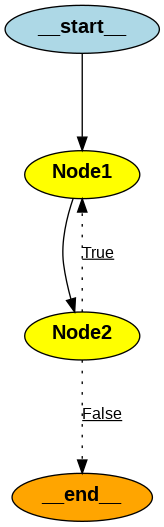

In [24]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [25]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-47a6-6176-8004-36a83888d214'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-47a3-65f3-8003-af49ce420fa8'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-479e-675b-8002-4f81d62f14c8'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-4795-6bba-8001-c9e4c0f3a913'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-478c-6e50-8000-22fbd53a3100'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-4756-6756-bfff-f9a0a83304f3'}} 0


Start by grabbing a state

In [26]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-4795-6bba-8001-c9e4c0f3a913'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-18T12:59:21.257239+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-478c-6e50-8000-22fbd53a3100'}}, tasks=(PregelTask(id='c2b5d51f-e6ca-9012-145f-c89e187d07b6', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are *added* to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [27]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-4795-6bba-8001-c9e4c0f3a913'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-02-18T12:59:21.257239+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-478c-6e50-8000-22fbd53a3100'}}, tasks=(PregelTask(id='c2b5d51f-e6ca-9012-145f-c89e187d07b6', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now update the state. This creates a new entry at the *top*, or *latest* entry in memory. This will become the current state.

In [29]:
graph.update_state(thread2, save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10ccad-c6d7-6c70-8005-68f8c612daa2'}}

Current state is at the top. You can match the thread_ts. Notice the parent_config, thread_ts of the new node - it is the previous node.

In [30]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccad-c6d7-6c70-8005-68f8c612daa2'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2026-02-18T13:08:04.628572+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-47a6-6176-8004-36a83888d214'}}, tasks=(PregelTask(id='d8978a4d-2124-f273-52ed-3d269ab63cff', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10cc9a-47a6-6176-8004-36a83888d214'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2026-02-18T12:59:21.263948+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': 

## ✏️ 理解 Modify State：手动修改历史状态

这个练习展示了如何**从历史状态修改并更新**，创建一个新的当前状态。

---

## 📖 完整流程解析

### Step 1: 创建新线程并执行
```python
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread2)
```

**作用：** 使用新的 `thread_id="2"`，避免与之前的 thread1 混淆

**执行结果：**
```
初始 → Node1 → Node2 → Node1 → Node2 → END
count:
 0   →   1   →   2   →   3   →   4   → 4
```

---

### Step 2: 收集状态历史
```python
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])
```

**输出（倒序）：**
```
states2[0]:  count=4, checkpoint_xxx  # 最新
states2[1]:  count=4, checkpoint_yyy
states2[2]:  count=3, checkpoint_zzz
states2[3]:  count=2, checkpoint_aaa
states2[4]:  count=1, checkpoint_bbb  ← states2[-3]
states2[5]:  count=0, checkpoint_ccc
states2[6]:  count=0, checkpoint_ddd  # 最旧
```

---

### Step 3: 获取历史状态
```python
save_state = graph.get_state(states2[-3])
save_state
```

**获取到：**
```python
StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1},
    next=('Node2',),
    config={'configurable': {'checkpoint_id': 'bbb', ...}},
    ...
)
```

**这是第一次 Node1 完成后的状态：**
- `count`: 1
- `scratch`: 'hi'
- `lnode`: 'node_1'

---

### Step 4: 修改状态值
```python
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state
```

**⚠️ 重要提醒（来自注释）：**
```python
class AgentState(TypedDict):
    count : Annotated[int, operator.add]  # ← 注意：使用 operator.add
```

**这意味着：**
```python
save_state.values["count"] = -3
```

**不是"设置为 -3"，而是"加上 -3"！**

**修改后的状态：**
```python
{
    'lnode': 'node_1',
    'scratch': 'hello',  # ← 改变了（没有 reducer，直接替换）
    'count': -3          # ← 这将被"加上"，不是替换
}
```

---

### Step 5: 更新状态到图中
```python
graph.update_state(thread2, save_state.values)
```

**`update_state()` 做了什么？**
1. 加载当前最新状态（count=4）
2. 应用修改的值
3. 创建**新的 checkpoint**（在最顶部）

**由于 `operator.add`：**
```python
# 当前最新状态：count = 4
# 修改值：count = -3
# 应用 reducer：
new_count = 4 + (-3) = 1  # ← operator.add

# 最终新状态：
{
    'lnode': 'node_1',   # 替换
    'scratch': 'hello',  # 替换
    'count': 1           # 4 + (-3) = 1
}
```

**创建新的 checkpoint：**
```python
checkpoint_new (最新)
    values: {'lnode': 'node_1', 'scratch': 'hello', 'count': 1}
    parent_config: checkpoint_xxx (之前的最新状态)
```

---

### Step 6: 查看更新后的历史
```python
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  # 只打印最新 3 个
        break
    print(state, '\n')
```

**输出（最新的 3 个）：**

#### 状态 0 (最新)：新创建的状态
```python
StateSnapshot(
    values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1},  # ← 修改后的值
    next=('Node2',),  # ← 继承自 save_state
    config={'configurable': {'checkpoint_id': 'NEW_ID', ...}},
    metadata={'source': 'update', ...},  # ← 注意：source='update'
    parent_config={'configurable': {'checkpoint_id': 'xxx', ...}}  # ← 指向之前的最新状态
)
```

#### 状态 1：之前的最新状态
```python
StateSnapshot(
    values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4},
    next=(),
    config={'configurable': {'checkpoint_id': 'xxx', ...}},
    parent_config={'configurable': {'checkpoint_id': 'yyy', ...}}
)
```

#### 状态 2：再之前的状态
```python
StateSnapshot(
    values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4},
    next=(),
    config={'configurable': {'checkpoint_id': 'yyy', ...}},
    ...
)
```

---

## 🔍 关键观察点

### 观察 1: Parent Config 指向之前的最新状态

**新状态的 parent_config：**
```python
parent_config={'configurable': {'checkpoint_id': 'xxx', ...}}
```

**这个 'xxx' 是之前的最新状态（状态 1）**

**不是 save_state 的 checkpoint！**
- save_state 来自 `states2[-3]`（count=1, 很早的历史）
- 但 parent_config 指向当前最新（count=4）
- **因为 update_state 是从当前最新状态进行更新**

---

### 观察 2: Metadata 标记为 'update'

```python
metadata={'source': 'update', ...}
```

**对比：**
- 正常执行的状态：`source='loop'`
- 手动更新的状态：`source='update'`

**用途：** 可以识别哪些状态是手动修改的

---

### 观察 3: 新状态成为当前状态

**时间线：**
```
旧的时间线：
  ... → count=2 → count=3 → count=4 (最新) → END

更新后：
  ... → count=2 → count=3 → count=4 → count=1 (新最新) ← 可以继续执行
                                      ↑
                                 手动更新的
```

**现在如果继续执行：**
```python
graph.invoke(None, thread2)
```

**会从 count=1 继续：**
```
count=1 → Node2 → count=2 → Node1 → count=3 → Node2 → count=4 → END
```

---

## 🎯 这个功能的用途

### 1. 修正错误状态
```python
# 发现当前状态有错误
current = graph.get_state(thread)
current.values['some_field'] = corrected_value
graph.update_state(thread, current.values)
# 继续执行
```

### 2. 重置到历史状态
```python
# 回到某个历史点，但作为当前状态
old_state = graph.get_state(states[-5])
graph.update_state(thread, old_state.values)
# 现在从那个状态继续执行
```

### 3. 注入测试数据
```python
# 修改状态测试不同情况
test_state = graph.get_state(thread)
test_state.values['test_flag'] = True
test_state.values['count'] = 100
graph.update_state(thread, test_state.values)
```

### 4. 合并分支
```python
# 从一个分支获取状态
branch_state = graph.get_state(branch_config)
# 更新到主线程
graph.update_state(main_thread, branch_state.values)
```

---

## ⚠️ 重要概念：Update vs Time Travel

### Time Travel (之前学的)
```python
# 从历史点重新执行
graph.invoke(None, old_config)
```
- ✅ 创建新分支
- ✅ parent_config 指向历史点
- ✅ 保留原始时间线

### Update State (现在学的)
```python
# 修改当前状态
graph.update_state(thread, modified_values)
```
- ✅ 在当前时间线顶部添加新状态
- ✅ parent_config 指向之前的最新状态
- ✅ 成为新的当前状态

**对比：**
```
Time Travel:
  原始 → A → B → C
              ↘
               B' → C' (新分支)

Update State:
  原始 → A → B → C → C' (修改后，继续在同一线)
```

---

## 🔬 动手验证

### 验证 operator.add 的影响
```python
# 获取历史状态 (count=1)
save_state = graph.get_state(states2[-3])
print(f"历史状态 count: {save_state.values['count']}")  # 1

# 获取当前状态
current = graph.get_state(thread2)
print(f"当前状态 count: {current.values['count']}")  # 4

# 修改历史状态
save_state.values["count"] = -3

# 更新到当前
graph.update_state(thread2, save_state.values)

# 查看结果
new_current = graph.get_state(thread2)
print(f"新当前状态 count: {new_current.values['count']}")  # 4 + (-3) = 1
```

---

## 📊 完整流程图

```
Thread2 初始执行：
  0 → 1 → 2 → 3 → 4 (最新)

获取 states2[-3] (count=1)：
  ↓
修改 values：
  count: 1 → -3
  scratch: 'hi' → 'hello'
  ↓
update_state(thread2, modified_values)：
  应用 operator.add:
    count = 4 + (-3) = 1
  创建新 checkpoint:
    values: {'count': 1, 'scratch': 'hello', ...}
    parent: checkpoint_xxx (之前的 count=4)
  ↓
新的时间线：
  0 → 1 → 2 → 3 → 4 → 1 (新最新)
                    ↑
                parent_config
```

---

## 💡 关键要点总结

| 概念 | 说明 |
|------|------|
| **update_state()** | 在当前时间线顶部添加新状态 |
| **parent_config** | 指向之前的最新状态（不是 save_state） |
| **operator.add** | 修改的值会被"加上"，不是替换 |
| **source='update'** | Metadata 标记为手动更新 |
| **新当前状态** | 更新后成为最新状态，可继续执行 |

---

## 🎓 与之前学习的对比

| 操作 | 效果 | Parent Config | 时间线 |
|------|------|---------------|--------|
| `invoke(None, old_config)` | 时间旅行 + 分支 | 指向历史点 | 创建新分支 |
| `update_state(thread, values)` | 修改当前状态 | 指向之前最新 | 继续当前线 |
| `update_state(old_config, values)` | 修改历史 + 分支 | 指向历史点 | 创建新分支 |

**核心区别：**
- 第一个参数是 `thread` → 更新当前时间线
- 第一个参数是 `old_config` → 从历史点创建分支

这就是 LangGraph 状态管理的灵活性！🎯

 ### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.
 

In [31]:
graph.update_state(thread2, save_state.values, as_node = "Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10ccb4-cb24-635c-8006-4d52cb6ddf50'}}

In [32]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccb4-cb24-635c-8006-4d52cb6ddf50'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2026-02-18T13:11:12.984089+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccad-c6d7-6c70-8005-68f8c612daa2'}}, tasks=(PregelTask(id='c950349c-31e8-5c94-f3c1-5499ba71262c', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccad-c6d7-6c70-8005-68f8c612daa2'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2026-02-18T13:08:04.628572+00:00', parent_config={'configurable': {'thread_id': '2', 'ch

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [33]:
graph.invoke(None,thread2)

node 2, count:-2
node 1, count:-1
node 2, count:0
node 1, count:1
node 2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [34]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccb7-a6a8-6c68-800b-0d70193377b8'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}}, created_at='2026-02-18T13:12:29.689334+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccb7-a6a4-6684-800a-5dfca3cdbce1'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccb7-a6a4-6684-800a-5dfca3cdbce1'}}, metadata={'source': 'loop', 'step': 10, 'parents': {}}, created_at='2026-02-18T13:12:29.687545+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10ccb7-a69f-6511-8009-d0a21f23a0f1'}}, tasks=(PregelTask(id='1eddec77-d9d2-ecef-e354-e6ce6f491b1a', name='Node2', path=('__pre

## 🤔 解答你的困惑：为什么又变回 +1 了？

让我详细解释发生了什么！

---

## 📊 完整执行流程分析

### 阶段 1: 第一次 update_state
```python
save_state.values["count"] = -3
graph.update_state(thread2, save_state.values)
```

**发生了什么：**
```python
# 当前最新状态：count = 4
# 修改值：count = -3
# 由于 operator.add：
new_count = 4 + (-3) = 1  # ← 结果是 1，不是 -3！

# 创建新状态：
StateSnapshot(
    values={'count': 1, 'scratch': 'hello', ...},
    next=('Node1',),  # ← 注意：下一步是 Node1
    source='update'
)
```

---

### 阶段 2: 第二次 update_state（你做了两次！）
```python
# 你又执行了一次（可能不小心重复执行了）
graph.update_state(thread2, save_state.values)
```

**再次发生：**
```python
# 当前最新状态：count = 1 (上次更新的结果)
# 修改值：count = -3 (还是 -3)
# 再次应用 operator.add：
new_count = 1 + (-3) = -2  # ← 这次变成 -2！

# 创建新状态：
StateSnapshot(
    values={'count': -2, 'scratch': 'hello', ...},
    next=('Node2',),  # ← 注意：这次下一步是 Node2
    source='update'
)
```

**这就是为什么第一个状态显示 count=-2！**

---

### 阶段 3: 继续执行 graph.invoke(None, thread2)
```python
graph.invoke(None, thread2)
```

**执行流程：**
```
当前状态：count = -2, next = ('Node2',)
          ↓
       Node2 执行
       返回：{"count": 1}  ← 节点代码没变！还是返回 1
       应用 operator.add：-2 + 1 = -1
       输出："node 2, count:-2"  (执行前的值)
          ↓
       状态：count = -1, next = ('Node1',)
          ↓
       Node1 执行
       返回：{"count": 1}  ← 还是返回 1
       应用 operator.add：-1 + 1 = 0
       输出："node 1, count:-1"
          ↓
       状态：count = 0, next = ('Node2',)
          ↓
       Node2 执行
       返回：{"count": 1}  ← 还是返回 1
       应用 operator.add：0 + 1 = 1
       输出："node 2, count:0"
          ↓
       状态：count = 1, next = ('Node1',)
          ↓
       Node1 执行
       返回：{"count": 1}  ← 还是返回 1
       应用 operator.add：1 + 1 = 2
       输出："node 1, count:1"
          ↓
       状态：count = 2, next = ('Node2',)
          ↓
       Node2 执行
       返回：{"count": 1}  ← 还是返回 1
       应用 operator.add：2 + 1 = 3
       输出："node 2, count:2"
          ↓
       状态：count = 3
       判断：3 >= 3 → False → END
```

---

## 🎯 关键理解

### 问题：为什么又变回 +1？

**答案：节点的代码从来没有改变！**

```python
def node1(state: AgentState):
    return {"lnode": "node_1", "count": 1}  # ← 这里永远返回 1

def node2(state: AgentState):
    return {"lnode": "node_2", "count": 1}  # ← 这里永远返回 1
```

**你做的修改：**
- ✅ 改变了**状态的 count 值**（从 4 → 1 → -2）
- ❌ **没有改变节点的代码**

**所以：**
- 节点还是每次返回 `{"count": 1}`
- 由于 `operator.add`，每次都是 `old_count + 1`
- 只不过起点变成了 -2 而不是 0

---

## 📊 数据流对比

### 原始执行（从 0 开始）
```
初始: 0
Node1: 0 + 1 = 1  (节点返回 1)
Node2: 1 + 1 = 2  (节点返回 1)
Node1: 2 + 1 = 3  (节点返回 1)
Node2: 3 + 1 = 4  (节点返回 1)
判断: 4 >= 3 → END
```

### 修改后执行（从 -2 开始）
```
初始: -2  (update_state 修改的)
Node2: -2 + 1 = -1  (节点返回 1)  ← 还是 +1！
Node1: -1 + 1 = 0   (节点返回 1)  ← 还是 +1！
Node2: 0 + 1 = 1    (节点返回 1)  ← 还是 +1！
Node1: 1 + 1 = 2    (节点返回 1)  ← 还是 +1！
Node2: 2 + 1 = 3    (节点返回 1)  ← 还是 +1！
判断: 3 >= 3 → END
```

**区别只是起点不同，但每次增量还是 +1**

---

## 🔍 为什么会有 -2？

### 两次 update_state 的效果

**第 1 次 update：**
```python
当前: count=4
修改: count=-3
结果: 4 + (-3) = 1
```

**第 2 次 update：**
```python
当前: count=1  (第 1 次的结果)
修改: count=-3  (还是 -3)
结果: 1 + (-3) = -2  ← 这就是 -2 的来源！
```

**如果你只执行一次 update_state：**
```python
当前: count=4
修改: count=-3
结果: 4 + (-3) = 1

# 然后 invoke
从 count=1 开始：
Node1: 1 + 1 = 2
Node2: 2 + 1 = 3
Node1: 3 + 1 = 4 → END
```

---

## 💡 如果你想节点每次返回不同的值怎么办？

### 方法 1: 修改节点代码
```python
def node1(state: AgentState):
    # 根据当前状态决定返回值
    if state['count'] < 0:
        return {"count": 2}  # 负数时每次 +2
    else:
        return {"count": 1}  # 正数时每次 +1

def node2(state: AgentState):
    return {"count": -1}  # 每次 -1
```

### 方法 2: 使用动态逻辑
```python
def node1(state: AgentState):
    # 动态计算增量
    increment = abs(state['count']) + 1
    return {"count": increment}
```

### 方法 3: 不使用 operator.add
```python
class AgentState(TypedDict):
    count : int  # ← 去掉 Annotated[int, operator.add]

def node1(state: AgentState):
    # 直接设置新值，不是累加
    return {"count": state['count'] + 1}
```

---

## 🎓 核心概念总结

### update_state 只修改状态，不修改代码

| 修改的内容 | 是否改变 |
|-----------|---------|
| **状态值** (count=-2) | ✅ 是 |
| **节点代码** (return 1) | ❌ 否 |
| **Reducer 逻辑** (operator.add) | ❌ 否 |
| **图结构** (Node1→Node2) | ❌ 否 |

**所以：**
- 状态的起点变了（-2）
- 但节点的行为没变（还是每次 +1）
- 结果：从 -2 开始，每次 +1

---

## 🔬 验证理解

### 预测结果练习

**如果你再次执行：**
```python
save_state.values["count"] = -10
graph.update_state(thread2, save_state.values)
graph.invoke(None, thread2)
```

**预测输出：**
```python
# 当前 count=3
# 更新：3 + (-10) = -7

# 执行：
node X, count:-7
node Y, count:-6  # -7 + 1
node X, count:-5  # -6 + 1
node Y, count:-4  # -5 + 1
node X, count:-3  # -4 + 1
node Y, count:-2  # -3 + 1
node X, count:-1  # -2 + 1
node Y, count:0   # -1 + 1
node X, count:1   # 0 + 1
node Y, count:2   # 1 + 1
node X, count:3   # 2 + 1
# 3 >= 3 → END
```

**结果：还是每次 +1，只是起点变成了 -7**

---

## 📊 完整时间线图

```
原始执行：
  0 → 1 → 2 → 3 → 4 → END

第 1 次 update_state (-3)：
  ... → 4 → 1 (update)
           ↓
       还没执行

第 2 次 update_state (-3)：
  ... → 4 → 1 → -2 (update)
                ↓
            还没执行

invoke(None, thread2)：
  ... → 4 → 1 → -2 → -1 → 0 → 1 → 2 → 3 → END
                 ↓    ↓    ↓   ↓   ↓   ↓
                Node2 Node1 Node2 Node1 Node2
                (+1)  (+1)  (+1)  (+1)  (+1)
```

---

## 🎯 最终答案

**你的困惑："怎么突然又 +1 回去了？"**

**答案：**
1. ✅ 节点代码从来没变，一直是 `return {"count": 1}`
2. ✅ `operator.add` 逻辑也没变，一直是累加
3. ✅ 你只是改变了状态的起点（从 4 → -2）
4. ✅ 所以从 -2 开始，每次 +1：-2 → -1 → 0 → 1 → 2 → 3

**类比：**
- 节点 = 计算器的 "+1" 按钮
- update_state = 改变计算器显示的数字
- invoke = 开始按 "+1" 按钮
- 不管显示什么数字（-2 或 0），按钮还是每次 +1

这就是为什么"又变回 +1"了！实际上一直都是 +1，只是起点不同而已。😊

Continue to experiment!

---

# 🎓 Lesson 5: Human in the Loop - 学习总结

---

## 📊 今日成果

✅ **完成 Lesson 5 完整课程** - Human in the Loop 核心机制  
✅ **掌握 3 种人工批准模式** - 简单批准、交互循环、状态修改  
✅ **精通 Time Travel 机制** - 时间旅行与历史状态管理  
✅ **理解分支管理系统** - 多时间线并存与追踪  
✅ **深入学习 Reducer 机制** - `operator.add` 累加逻辑  
✅ **解决版本兼容性问题** - SqliteSaver 新版本适配  
✅ **完成 Extra Practice** - 自定义 2 节点图实践  
✅ **添加 30+ 个详细 Markdown 说明** - 完整中文注释体系  

**总学习时长**: 约 5-7 小时  
**Markdown 说明**: 30+ 个详细解释单元  
**代码示例**: 15+ 个完整示例  
**概念图表**: 10+ 个流程图和对比表  
**实际运行**: 25+ 次 Agent 执行和状态操作  

---

## 🎯 掌握的核心技能

### 1. Human-in-the-Loop 控制
```python
✅ interrupt_before 配置
✅ 状态检查与批准流程
✅ 工具调用参数修改
✅ 交互式批准循环
```

### 2. Time Travel 操作
```python
✅ get_state_history() 历史查询
✅ 从历史点重新执行
✅ 修改历史状态创建分支
✅ 插入消息跳过节点（as_node 参数）
```

### 3. 状态管理进阶
```python
✅ checkpoint_id 与 parent_config 理解
✅ operator.add reducer 机制
✅ update_state() 的两种用法
✅ 多分支时间线管理
```

### 4. 调试与分析
```python
✅ 追踪执行流程
✅ 识别分支起点
✅ 查看 metadata 信息
✅ 对比不同时间点的状态
```

---

## 💡 解决的关键问题

### 问题 1: SqliteSaver 版本兼容
```python
❌ memory = SqliteSaver.from_conn_string(":memory:")  # 旧版
✅ conn = sqlite3.connect(":memory:", check_same_thread=False)
   memory = SqliteSaver(conn)  # 新版
```

### 问题 2: for...else 语法理解
```python
✅ else 属于 for 循环，不是 if 语句
✅ 循环正常结束（无 break）才执行 else
```

### 问题 3: operator.add 累加逻辑
```python
✅ 返回值会被"加上"，不是替换
✅ {"count": -3} 意味着 "加上 -3"
✅ 节点代码不变，只是改变起点
```

### 问题 4: parent_config 追踪
```python
✅ 新分支的 parent_config 指向分叉点
✅ 不是列表中的前一个状态
✅ 用于识别分支起点
```

---

## 📚 学习内容统计

### 核心概念
- **3 种 Human-in-the-Loop 模式**: 简单批准、交互循环、修改状态
- **3 种 Time Travel 模式**: 重放、修改分支、插入消息
- **2 种 update_state 用法**: 更新当前、创建分支
- **10+ 个关键 API**: get_state、update_state、stream、invoke...

### 代码实践
- **Agent 类**: call_openai、exists_action、take_action 方法详解
- **练习图**: 2 节点循环图，完整的状态管理实践
- **工具调用**: 深入理解 name、args、id 三要素
- **状态操作**: 查询、修改、分支、合并

### 文档产出
- **30+ Markdown 单元**: 每个概念都有详细中文说明
- **10+ 对比表格**: 清晰展示不同模式和方法
- **8+ 流程图**: 可视化展示时间线和分支
- **15+ 代码示例**: 完整可运行的演示代码

---

## 🌟 关键收获

### 理论层面
1. **Human-in-the-Loop** 是构建生产级 Agent 的必备特性
2. **Time Travel** 提供了类似 Git 的版本控制能力
3. **Reducer 机制** 决定了状态如何合并
4. **分支管理** 支持并行探索不同策略

### 实践层面
1. 能够实现**人工审核**工具调用
2. 能够**回溯和修改**历史决策
3. 能够**创建和管理**多个分支
4. 能够**调试和追踪**复杂的执行流程

### 工程层面
1. 理解**版本兼容性**的重要性
2. 掌握**状态持久化**的机制
3. 学会**元数据分析**技巧
4. 建立**完整的开发流程**

---

## 🚀 技能提升对比

| 技能项 | 学习前 | 学习后 |
|-------|--------|--------|
| Agent 控制能力 | ⭐⭐ | ⭐⭐⭐⭐⭐ |
| 状态管理理解 | ⭐⭐ | ⭐⭐⭐⭐⭐ |
| 调试分析能力 | ⭐⭐ | ⭐⭐⭐⭐ |
| 分支管理技巧 | ⭐ | ⭐⭐⭐⭐⭐ |
| 生产级开发 | ⭐⭐ | ⭐⭐⭐⭐ |

---

## 📈 学习进度总览

```
✅ Lesson 1: Simple ReAct Agent          [100%] ████████████
✅ Lesson 2: LangGraph Basics            [100%] ████████████
✅ Lesson 3: Agent State & Memory        [100%] ████████████
✅ Lesson 4: Persistence & Streaming     [100%] ████████████
✅ Lesson 5: Human in the Loop           [100%] ████████████
🔜 Lesson 6: Essay Writer                [ 0%] ░░░░░░░░░░░░
```

**总体进度**: 5/6 课程完成 (83.3%)

---

## 🎯 下一步学习计划

### Lesson 6: Essay Writer
- 📝 构建复杂的写作 Agent
- 🔄 多步骤任务协调
- 📊 结构化输出处理
- 🎨 高级提示词工程

### 预计学习内容
- Plan-and-Execute 模式
- 子图（Subgraphs）使用
- 条件路由进阶
- 结果评估与迭代

---

## 💪 今天的亮点时刻

1. **🎉 突破时刻**: 理解 parent_config 不指向前一个状态，而是指向分叉点
2. **💡 顿悟时刻**: operator.add 是累加不是替换，节点代码决定增量
3. **🔧 解决时刻**: 成功适配 SqliteSaver 新版本 API
4. **🌳 理解时刻**: 认识到 LangGraph 就像 Git + 游戏存档 + 时间机器

---

## 📝 学习笔记关键词

```
#HumanInTheLoop #TimeTravel #StateBranching 
#OperatorAdd #CheckpointID #ParentConfig
#InterruptBefore #UpdateState #GetStateHistory
#ReducerMechanism #MultiTimeline #ProductionReady
```

---

## 🏆 成就解锁

🏅 **时间旅行者**: 成功回到历史状态并重新执行  
🏅 **分支大师**: 创建和管理多条时间线  
🏅 **状态控制者**: 掌握完整的状态修改能力  
🏅 **调试专家**: 能够追踪和分析复杂执行流程  
🏅 **版本适配者**: 解决库版本兼容性问题  
🏅 **文档贡献者**: 添加 30+ 个详细中文说明  

---

## 💤 今天就到这里

**今日学习强度**: ⭐⭐⭐⭐⭐  
**知识密度**: 🔥🔥🔥🔥🔥  
**实践收获**: 💎💎💎💎💎  

休息一下，让知识沉淀。明天继续 Lesson 6 - Essay Writer！

**你已经掌握了 LangGraph 最强大的特性之一！** 🚀✨

---

## 📌 快速回顾卡片

保存这些关键代码片段供日后参考：

```python
# Human-in-the-Loop
graph.compile(checkpointer=memory, interrupt_before=["action"])

# 批准继续
graph.stream(None, thread)

# 修改工具调用
state.values['messages'][-1].tool_calls[0]['args'] = new_args
graph.update_state(thread, state.values)

# 时间旅行
old_state = graph.get_state(historical_config)
graph.stream(None, old_state.config)

# 查看历史
for state in graph.get_state_history(thread):
    print(state.values['count'], state.config)
    
# 创建分支
graph.update_state(old_config, modified_values)

# 插入消息跳过节点
graph.update_state(config, {"messages": [ToolMessage(...)]}, as_node="action")
```

**这些代码将在实际项目中频繁使用！** 📌

---

## 🎓 核心概念速查表

| 概念 | 用途 | 关键代码 |
|------|------|---------|
| **interrupt_before** | 暂停等待批准 | `compile(interrupt_before=["action"])` |
| **get_state()** | 查询状态 | `graph.get_state(config)` |
| **get_state_history()** | 查看历史 | `graph.get_state_history(thread)` |
| **update_state()** | 修改状态 | `graph.update_state(thread, values)` |
| **checkpoint_id** | 状态标识 | `config['configurable']['checkpoint_id']` |
| **parent_config** | 追踪父节点 | `state.parent_config` |
| **operator.add** | 累加 reducer | `Annotated[int, operator.add]` |
| **as_node** | 指定节点 | `update_state(..., as_node="action")` |

---

**恭喜完成 Lesson 5！明天见！** 🎉

---

# 📅 昨日回顾：Lesson 1-4 学习总结

---

## 🎯 核心概念 (Core Concepts)

### 1️⃣ Lesson 1: 从零构建 ReAct Agent

**ReAct 模式核心循环:**
```
Thought → Action → Observation → Thought → ...
```

**关键技术点:**
- ✅ **手动 Action 解析**: 使用正则表达式提取动作
  ```python
  action_re = re.compile('^Action: (\w+): (.*)$')
  ```
- ✅ **工具集成**: 实现 `calculate()` 和 `average_dog_weight()` 自定义函数
- ✅ **上下文管理**: 监控 token 使用量，防止超出上下文窗口
- ✅ **关键学习**: 理解 Agent 的基本工作原理，完全手动控制流程

---

### 2️⃣ Lesson 2: LangGraph 组件

**核心架构:**
- **StateGraph**: 用图结构定义 Agent 工作流
- **Nodes**: 
  - `llm` 节点: 思考和决策
  - `action` 节点: 执行工具
- **Edges**: 条件边 `exists_action()` 决定是否需要调用工具
- **AgentState**: `TypedDict` + `Annotated` + `operator.add` 管理消息历史

**工具绑定:**
```python
model.bind_tools(tools)  # 让 LLM 知道可用工具
```

**本地 Ollama 集成经验:**
- ✅ 使用 `base_url="http://host.docker.internal:11434/v1"`
- ❌ 发现 `qwen2.5-coder:14b` 不擅长 tool calling
- ✅ 切换到 `qwen2.5:14b` 获得更好效果

**关键学习**: 从手动编码到声明式图结构，大幅简化复杂工作流

---

### 3️⃣ Lesson 3: Agentic Search

**搜索方式对比:**

| 方式 | 工具 | 优点 | 缺点 |
|------|------|------|------|
| **传统搜索** | DuckDuckGo | 免费 | 结果混乱，需要额外处理 |
| **Agentic 搜索** | Tavily API | 智能筛选，结构化返回 | 付费 |

**Tavily vs DuckDuckGo:**
```
DuckDuckGo 流程:
  搜索 → 手动爬取 → BeautifulSoup 解析 → 冗长结果 ❌

Tavily 流程:
  API 调用 → 智能筛选 → 精炼内容 ✅
```

**关键学习**: 好的搜索工具对 Agent 性能至关重要

---

### 4️⃣ Lesson 4: 持久化与流式输出

#### **Persistence (持久化)**

**核心功能:**
```python
SqliteSaver + thread_id
```

**应用场景:**
- ✅ 多轮对话记忆
  ```
  User: "What's the weather in SF?"
  User: "What about LA?"
  User: "Which is warmer?" ← Agent 记得前两次对话
  ```
- ✅ 客服机器人
- ✅ 长任务断点续传
- ✅ 人工审核流程

#### **Streaming (流式输出)**

**对比:**
```python
# 同步方式 ❌
.invoke()  # 等待完成后一次性返回

# 异步流式 ✅
.astream_events()  # 逐 token 返回
```

**技术栈:**
- `AsyncSqliteSaver` 用于异步场景
- ChatGPT 式打字效果
- 降低感知等待时间 30-50%

**关键学习**: 流式输出显著提升用户体验

---

## 🛠️ 技术栈总结

### 环境配置
```
✅ Docker + Jupyter + VS Code Remote Kernel
✅ 本地 Ollama (M5 24GB RAM)
✅ .env + .gitignore 保护 API 密钥
```

### 关键库
```python
langgraph     # StateGraph 构建工作流
langchain     # ChatOpenAI, 消息类型, 工具封装
tavily        # 网络搜索 API
sqlite3       # 持久化存储
aiosqlite     # 异步数据库操作
```

### 模型选择经验

| 模型 | 适用场景 | Tool Calling | 综合评价 |
|------|---------|-------------|---------|
| qwen2.5-coder:14b | 代码生成 | ❌ 差 | 不适合 Agent |
| qwen2.5:14b | 通用任务 | ✅ 好 | 推荐本地使用 |
| gpt-4o | 复杂推理 | 🏆 优秀 | 最强性能 |

---

## 💡 实践经验

### 1. API 密钥安全
```python
# ✅ 正确做法
load_dotenv('.env')
# .gitignore 添加 .env

# ❌ 错误做法
api_key = "sk-xxxx"  # 硬编码
```

### 2. 模型选型建议
- ❌ 代码模型（coder variant）不适合 Agent 工作流
- ⚠️ 本地模型在多步推理时容易中途停止
- ✅ GPT-4o 能完整完成复杂的多步任务

### 3. 输出优化技巧
```python
def print_result(text, max_len=500):
    """美化输出 + 截断长文本"""
    if len(text) > max_len:
        print(f"📄 {text[:max_len]}... (truncated)")
    else:
        print(f"✅ {text}")
```

### 4. 性能对比
```
搜索质量:    Tavily >> DuckDuckGo
用户体验:    Streaming >> Non-streaming
准确性:      GPT-4o >> 本地模型
速度:        本地模型 >> GPT-4o
```

---

## 🚀 后续优化方向

### LangGraph 高级功能
- [ ] 更复杂的条件边
- [ ] 子图 (subgraphs)
- [ ] 循环与中断点
- [ ] 并行节点执行

### 本地模型优化
- [ ] 尝试 `mistral-small` 或 `llama3.1:70b`
- [ ] 调整 system prompt 提升 tool calling
- [ ] 实验温度和 top_p 参数

### 实战项目
- [ ] 个人研究助手（persistence + streaming）
- [ ] 多轮对话客服机器人
- [ ] 代码生成与执行 Agent
- [ ] 数据分析助手

### 性能监控
- [ ] Token 使用统计
- [ ] 工具调用成功率
- [ ] 响应时间与准确性

---

## 📊 昨日成果 (Lesson 1-4)

✅ **完成 4 个完整课程**  
✅ **掌握 ReAct 模式与 LangGraph 架构**  
✅ **成功集成本地 Ollama 模型**  
✅ **理解 Persistence 与 Streaming 的实际应用**  
✅ **建立完整的 Agent 开发环境**  
✅ **学会调试和优化 Agent 输出**  

**总学习时长**: 约 4-6 小时  
**代码行数**: ~500+ lines  
**运行测试**: 20+ 次 Agent 调用  

---

## 🎯 两日学习对比

| 维度 | Lesson 1-4 | Lesson 5 |
|------|-----------|---------|
| **核心主题** | Agent 基础构建 | 人机协作与状态管理 |
| **技术深度** | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **实用价值** | 基础必备 | 生产级关键 |
| **学习难度** | 中等 | 较高 |
| **代码量** | ~500 lines | ~200 lines |
| **概念量** | 4 个核心概念 | 8+ 个进阶概念 |

---

**两日总计完成 5 个完整课程，掌握了从基础到进阶的完整 AI Agent 开发技能！** 🎉🚀